In [221]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
import sys
import os 
sys.path.append(os.path.abspath('../'))
import torch
from time import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import clear_output

device = 'cuda'

from convolutions import *
from utils_fns import *
from utils_general import update_sigma_linear, run_scheduler_step, plt_errors, show_with_error
from optimizations import *

# Example Usages

In [3]:
sigma1, sigma2 = 0.1, 0.1

grid_size = 100
x1 = np.linspace(-0.3, 0.3, grid_size)
x2 = np.linspace(-0.3, 0.3, grid_size)
X1, X2 = np.meshgrid(x1, x2)
x = np.stack([X1, X2], axis=2).reshape(-1, 2)
x = torch.tensor(x, dtype=torch.float32).to(device)

# gauss
y = gaussian_nd(x, sigma1).reshape((grid_size,grid_size))

# gauss grad
grad = gauss_grad(x, sigma1)
y0, y1 = grad[:,0].reshape((grid_size,grid_size)), grad[:,1].reshape((grid_size,grid_size))

# gauss hess
hess = gauss_hessian(x, sigma1, device=device)
y00, y01, y11 = hess[:,0,0].reshape((grid_size,grid_size)), hess[:,0,1].reshape((grid_size,grid_size)), hess[:,1,1].reshape((grid_size,grid_size))

In [75]:
# convolution 1D
n_samples = 1000
points = torch.tensor([[0.2]]).to(device)
sigma1, sigma2 = 0.1, 0.1
f_args = {'sigma': sigma1}
kernel_args = {'sigma': sigma2}
# usage examples
# 1d
print("Value: ")
sampler = 'importance_gauss'
sampler_args = {'sigma':sigma2, 'is_antithetic':True}
sampled_res = convolve(gaussian_nd, gaussian_nd, points, n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device)

res = gaussian_nd(points[0].unsqueeze(0), sigma=(sigma1**2 + sigma2**2)**0.5)
print("Sampled the convolution result:")
print(sampled_res)

print("True result: ")
print(res)

# gradient kernel with gradient IS
print("\nGrad: ")
sampler = 'importance_gradgauss'
sampler_args = {'sigma':sigma2, 'is_antithetic':True, 'dir':0}
sampled_res = convolve(gaussian_nd, gauss_grad, points,  n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).item()

res = gauss_grad(points[0].unsqueeze(0), sigma=(sigma1**2 + sigma2**2)**0.5)
print("Sampled the convolution result:")
print(sampled_res)

print("True result: ")
print(res)

# Hessian kernel with hessian IS
print("\nHessian: ")
sampler = 'importance_hessgauss'
sampler_args = {'sigma':sigma2, 'is_antithetic':True, 'dir':(0,0)}
sampled_res = convolve(gaussian_nd, gauss_hessian, points,  n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).item()

res = gauss_hessian(points[0].unsqueeze(0), sigma=(sigma1**2 + sigma2**2)**0.5, device=device)
print("Sampled the convolution result:")
print(sampled_res)


print("True result: ")
print(res)


Value: 
torch.Size([2000]) torch.Size([2000])
Sampled the convolution result:
tensor(1.0254, device='cuda:0')
True result: 
tensor([1.0378], device='cuda:0')

Grad: 
torch.Size([2000, 1]) torch.Size([2000, 1])
Sampled the convolution result:
-10.165163040161133
True result: 
tensor([[-10.3777]], device='cuda:0')

Hessian: 
torch.Size([2000, 1, 1]) torch.Size([2000, 1, 1])
Sampled the convolution result:
49.931800842285156
True result: 
tensor([[[51.8884]]], device='cuda:0')


In [74]:
# convolution 2D
n_samples = 10000
points = torch.tensor([[0.3, 0.15]]).to(device)
sigma1, sigma2 = 0.1, 0.1
f_args = {'sigma': sigma1}
kernel_args = {'sigma': sigma2, }
# usage examples
# 1d
print("Value: ")
sampler = 'importance_gauss'
sampler_args = {'sigma':sigma2, 'is_antithetic':True}
sampled_res = convolve(gaussian_nd, gaussian_nd, points, n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device)

res = gaussian_nd(points[0].unsqueeze(0), sigma=(sigma1**2 + sigma2**2)**0.5)
print("Sampled the convolution result:")
print(sampled_res)

print("True result: ")
print(res)

# gradient kernel with gradient IS
print("\nGrad: ")
sampler = 'importance_gradgauss'
sampler_args = {'sigma':sigma2, 'is_antithetic':True, 'dir':0}
sampled_res0 = convolve(gaussian_nd, gauss_grad, points,  n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).item()
sampler_args = {'sigma':sigma2, 'is_antithetic':True, 'dir':1}
sampled_res1 = convolve(gaussian_nd, gauss_grad, points,  n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).item()

sampled_res = [sampled_res0, sampled_res1]
res = gauss_grad(points[0].unsqueeze(0), sigma=(sigma1**2 + sigma2**2)**0.5)
print("Sampled the convolution result:")
print(sampled_res)

print("True result: ")
print(res)

# Hessian kernel with hessian IS
print("\nHessian: ")
sampler = 'importance_hessgauss'
sampler_args = {'sigma':sigma2, 'is_antithetic':True, 'dir':(0,0)}
sampled_res00 = convolve(gaussian_nd, gauss_hessian, points,  n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).item()
sampler_args = {'sigma':sigma2, 'is_antithetic':True, 'dir':(1,1)}
sampled_res11 = convolve(gaussian_nd, gauss_hessian, points,  n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).item()
sampler_args = {'sigma':sigma2, 'is_antithetic':True, 'dir':(1,0)}
sampled_res10= convolve(gaussian_nd, gauss_hessian, points,  n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).item()

sampled_res = [[sampled_res00, sampled_res10],[sampled_res10, sampled_res11]]

res = gauss_hessian(points[0].unsqueeze(0), sigma=(sigma1**2 + sigma2**2)**0.5, device=device)
print("Sampled the convolution result:")
print(sampled_res)


print("True result: ")
print(res)

# Hessian vector product
print("\nHessian vector product: ")
eps = 0.03
sampler_args = {'sigma':sigma2, 'is_antithetic':True}
random_vec = torch.randn(2).to(device)
HV_func = smoothFn_hv_fd(gaussian_nd,n=n_samples, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device, epsilon=eps)
sampled_HV = HV_func(points[0].unsqueeze(0), random_vec)
print("Sampled the convolution result:")
print(sampled_HV)
true_res = torch.matmul(gauss_hessian(points[0].unsqueeze(0), sigma=(sigma1**2 + sigma2**2)**0.5, device=device), random_vec)
print("True result: ")
print(true_res)


Value: 
torch.Size([20000]) torch.Size([20000])
Sampled the convolution result:
tensor(0.4790, device='cuda:0')
True result: 
tensor([0.4779], device='cuda:0')

Grad: 
torch.Size([20000, 1]) torch.Size([20000, 1])
torch.Size([20000, 1]) torch.Size([20000, 1])
Sampled the convolution result:
[-7.129641056060791, -3.698178768157959]
True result: 
tensor([[-7.1685, -3.5842]], device='cuda:0')

Hessian: 
torch.Size([20000, 1, 1]) torch.Size([20000, 1, 1])
torch.Size([20000, 1, 1]) torch.Size([20000, 1, 1])
torch.Size([20000, 1, 1]) torch.Size([20000, 1, 1])
Sampled the convolution result:
[[85.27728271484375, 53.037391662597656], [53.037391662597656, 3.2685389518737793]]
True result: 
tensor([[[83.6325, 53.7637],
         [53.7637,  2.9869]]], device='cuda:0')

Hessian vector product: 
torch.Size([20000, 1]) torch.Size([20000, 1])
torch.Size([20000, 1]) torch.Size([20000, 1])
torch.Size([20000, 1]) torch.Size([20000, 1])
torch.Size([20000, 1]) torch.Size([20000, 1])
Sampled the convolution

# Mse and bias

In [324]:
def variance(samples, gt, axis=0):
    '''
    Calculate the MSE
    samples is nxmxm,
    gt is mxm
    '''
    if axis == 0:
        differences = samples - gt  
    elif axis == 1:
        differences = (samples.T - gt).T
    variances = (differences ** 2).mean(axis=axis)
    return variances

In [375]:
min_sample = 1
add_sample = 100
step = 4
number_of_samples = np.arange(min_sample, min_sample+add_sample, step)
samples_length = len(number_of_samples)

sigma1, sigma2 = 0.1, 0.1
f_args = {'sigma': sigma1}
kernel_args = {'sigma': sigma2}

x = torch.rand(2, device=device)*0.5 - 0.5
x = torch.tensor([0.3, 0.15], requires_grad=True, device=device)
n = 1000 # number of iterations for each point

# compute true grad and hess
new_sigma = (sigma1**2 + sigma2**2)**0.5
diff_val = gauss_grad(x.clone().detach().unsqueeze(0), new_sigma).cpu().detach().numpy()
true_hess_val = gauss_hessian(x.clone().detach().unsqueeze(0), new_sigma, device=device).cpu().detach().numpy()
diff = np.tile(diff_val, (samples_length, 1))
true_hess = np.tile(true_hess_val, (samples_length, 1, 1))

In [376]:
hess_conv_var_uniform = np.zeros((samples_length, 2, 2))
hess_conv_mean_uniform = np.zeros((samples_length, 2, 2))
hess_conv_var_importance = np.zeros((samples_length, 2, 2))
hess_conv_mean_importance = np.zeros((samples_length, 2, 2))
grad_var_uniform = np.zeros((2, samples_length))
grad_mean_uniform = np.zeros((2, samples_length))
grad_var_importance = np.zeros((2, samples_length))
grad_mean_importance = np.zeros((2, samples_length))

for i in tqdm(range(samples_length)):
    distribution_hess_uniform = np.zeros((n,2,2))
    distribution_grad_uniform = np.zeros((2, n))
    hess_importance = np.zeros((n,2,2))
    grad_importance = np.zeros((2, n))
    start_time = time.time()
    for j in range(n):
        # uniform samples
        sampler = 'uniform'
        sampler_args = {'min': -1, 'max': 1}
        convolved_value = convolve(gaussian_nd, gauss_hessian, x.unsqueeze(0), n=number_of_samples[i], sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device)
        distribution_hess_uniform[j,:,:] = convolved_value.detach().cpu().numpy() # hessian
        
        distribution_grad_uniform[:, j] = convolve(gaussian_nd, gauss_grad, x.unsqueeze(0), n=number_of_samples[i],sampler=sampler, 
                                                   f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).cpu().detach().numpy()
        # importance samples
        sampler = 'importance_gradgauss'
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':0}
        grad_importance[0, j] = convolve(gaussian_nd, gauss_grad, x.unsqueeze(0), n=number_of_samples[i], sampler=sampler, 
                                         f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).cpu().detach().numpy().item()
        
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':1}
        grad_importance[1, j] = convolve(gaussian_nd, gauss_grad, x.unsqueeze(0), n=number_of_samples[i], sampler=sampler,
                                         f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).cpu().detach().numpy().item()
        
        sampler = 'importance_hessgauss'
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':(0,0)}
        hess_importance[j, 0, 0] = convolve(gaussian_nd, gauss_hessian, x.unsqueeze(0), n=number_of_samples[i], sampler=sampler, 
                                            f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).cpu().detach().numpy().item()
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':(1,1)}
        hess_importance[j, 1, 1] = convolve(gaussian_nd, gauss_hessian, x.unsqueeze(0), n=number_of_samples[i], sampler=sampler, 
                                            f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).cpu().detach().numpy().item()
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':(1,0)}
        hess_importance[j, 1, 0] = hess_importance[j, 0, 1] = convolve(gaussian_nd, gauss_hessian, x.unsqueeze(0), n=number_of_samples[i], sampler=sampler,
                                                                       f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).cpu().detach().numpy().item()
           
    # print("Number of samples: ", number_of_samples[i])
    # print("Time taken: ", time.time()-start_time)
    hess_conv_mean_uniform[i, :, :] = np.mean(distribution_hess_uniform, axis=0)
    hess_conv_var_uniform[i, :, :] = variance(distribution_hess_uniform, true_hess_val, axis=0)
    hess_conv_mean_importance[i, :, :] = np.mean(hess_importance, axis=0)
    hess_conv_var_importance[i, :, :] = variance(hess_importance, true_hess_val, axis=0)
    
    grad_mean_uniform[:, i] = np.mean(distribution_grad_uniform, axis=1)
    grad_var_uniform[:, i] = variance(distribution_grad_uniform, diff_val, axis=1)
    grad_mean_importance[:, i] = np.mean(grad_importance, axis=1)
    grad_var_importance[:, i] = variance(grad_importance, diff_val, axis=1)
    


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [03:46<00:00,  9.08s/it]


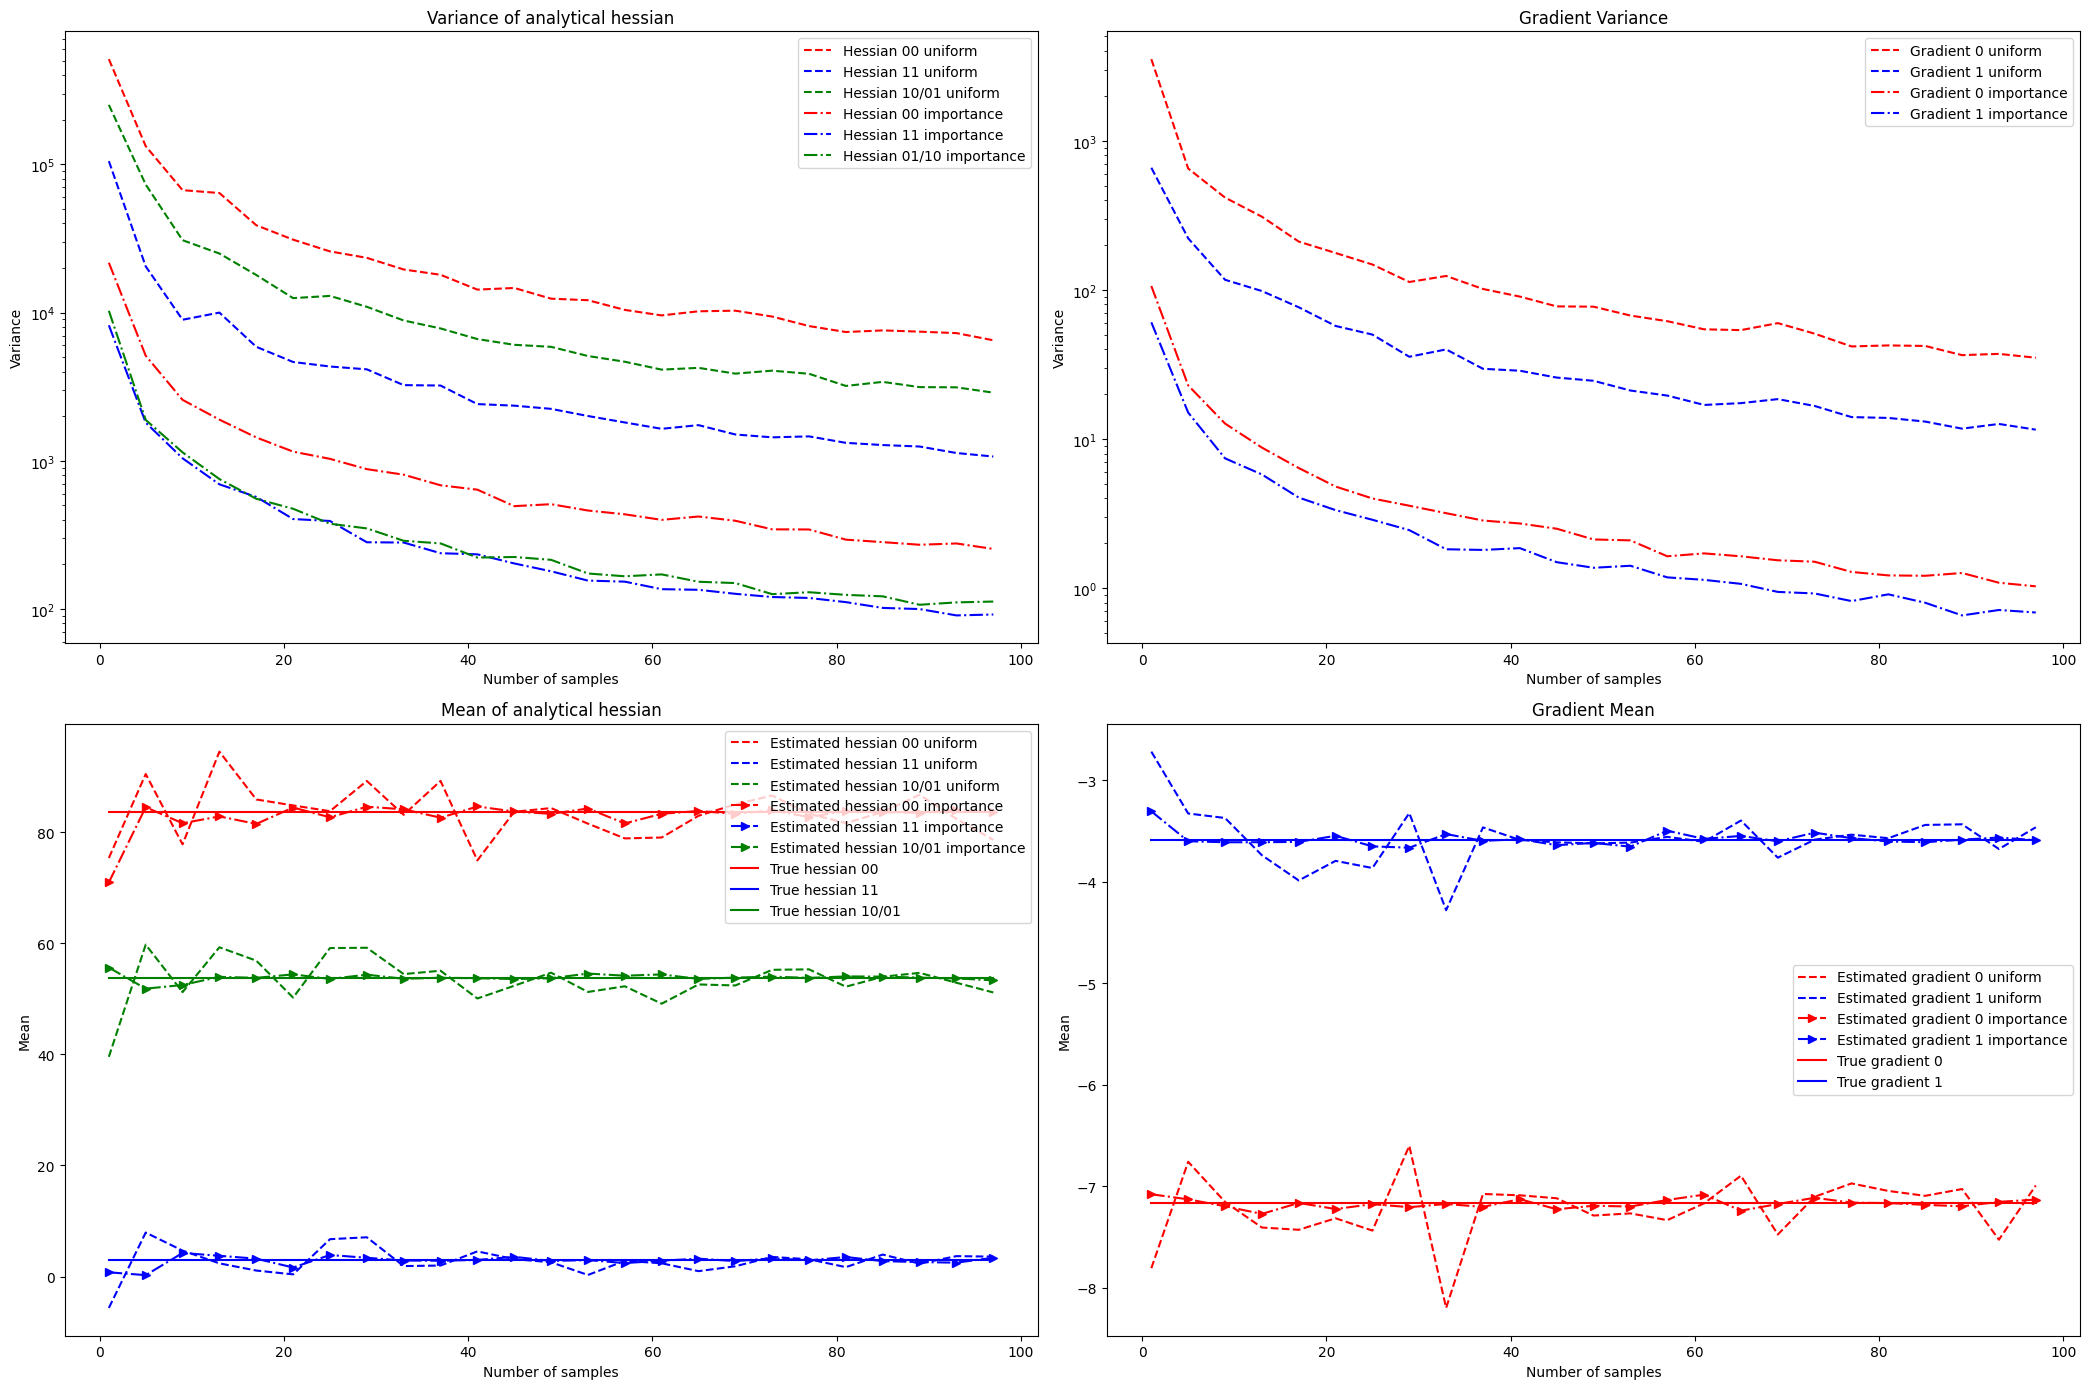

In [377]:
plt.figure(figsize=(21,14))
plt.subplot(2,2,1)
plt.plot(number_of_samples, hess_conv_var_uniform[:,0,0], color='red', linestyle='--', label="Hessian 00 uniform")
plt.plot(number_of_samples, hess_conv_var_uniform[:,1,1], color='blue', linestyle='--', label="Hessian 11 uniform")
plt.plot(number_of_samples, hess_conv_var_uniform[:,1,0], color='green', linestyle='--', label="Hessian 10/01 uniform")
plt.plot(number_of_samples, hess_conv_var_importance[:,0,0], color='red', linestyle='-.', label="Hessian 00 importance")
plt.plot(number_of_samples, hess_conv_var_importance[:,1,1], color='blue', linestyle='-.', label="Hessian 11 importance")
plt.plot(number_of_samples, hess_conv_var_importance[:,0,1], color='green', linestyle='-.', label="Hessian 01/10 importance")
plt.title("Variance of analytical hessian")
plt.xlabel("Number of samples")
plt.yscale('log')
# plt.ylim(bottom=10)
plt.ylabel("Variance")
plt.legend()

plt.subplot(2,2,2)
plt.plot(number_of_samples, grad_var_uniform[0,:], color='red', linestyle='--', label="Gradient 0 uniform")
plt.plot(number_of_samples, grad_var_uniform[1,:], color='blue', linestyle='--', label="Gradient 1 uniform")
plt.plot(number_of_samples, grad_var_importance[0,:], color='red', linestyle='-.', label="Gradient 0 importance")
plt.plot(number_of_samples, grad_var_importance[1,:], color='blue', linestyle='-.', label="Gradient 1 importance")
plt.xlabel("Number of samples")
plt.ylabel("Variance")
plt.yscale('log')
# plt.ylim(bottom=1)
plt.title("Gradient Variance")
plt.legend()

plt.subplot(2,2,3)
plt.plot(number_of_samples, hess_conv_mean_uniform[:,0,0], color='red', linestyle='--', label="Estimated hessian 00 uniform")
plt.plot(number_of_samples, hess_conv_mean_uniform[:,1,1], color='blue', linestyle='--', label="Estimated hessian 11 uniform")
plt.plot(number_of_samples, hess_conv_mean_uniform[:,1,0], color='green', linestyle='--', label="Estimated hessian 10/01 uniform")
plt.plot(number_of_samples, hess_conv_mean_importance[:,0,0], color='red', linestyle='-.', marker='>', label="Estimated hessian 00 importance")
plt.plot(number_of_samples, hess_conv_mean_importance[:,1,1], color='blue', linestyle='-.', marker='>', label="Estimated hessian 11 importance")
plt.plot(number_of_samples, hess_conv_mean_importance[:,1,0], color='green', linestyle='-.', marker='>', label="Estimated hessian 10/01 importance")
plt.plot(number_of_samples, true_hess[:,0,0], color='red', label="True hessian 00")
plt.plot(number_of_samples, true_hess[:,1,1], color='blue', label="True hessian 11")
plt.plot(number_of_samples, true_hess[:,1,0], color='green', label="True hessian 10/01")
plt.plot()
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("Mean of analytical hessian")
plt.tight_layout()
plt.legend()

plt.subplot(2,2,4)
plt.plot(number_of_samples, grad_mean_uniform[0,:], color='red', linestyle='--', label="Estimated gradient 0 uniform")
plt.plot(number_of_samples, grad_mean_uniform[1,:], color='blue', linestyle='--', label="Estimated gradient 1 uniform")
plt.plot(number_of_samples, grad_mean_importance[0,:], color='red', linestyle='-.', marker='>', label="Estimated gradient 0 importance")
plt.plot(number_of_samples, grad_mean_importance[1,:], color='blue', linestyle='-.', marker='>', label="Estimated gradient 1 importance")
plt.plot(number_of_samples, diff[:,0], color='red', label="True gradient 0")
plt.plot(number_of_samples, diff[:,1], color='blue', label="True gradient 1")
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("Gradient Mean")
plt.legend()
plt.tight_layout()
plt.show()


## HVP epsilon

In [342]:
min_sample = 1
add_sample = 100
step = 4
sigma1, sigma2 = 0.1, 0.1
number_of_samples = np.arange(min_sample, min_sample+add_sample, step) # for first plot against samples
epses = np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 3, 5])*sigma2 # for second plot against epsilon
samples_length = len(number_of_samples)

f_args = {'sigma': sigma1}
kernel_args = {'sigma': sigma2}

x = (torch.rand(2, device=device) - 0.5)*3*sigma2
# x = torch.tensor([0.3, 0.15], requires_grad=True, device=device)
n = 1000 # number of iterations for each point
eps = 0.3*sigma2
random_vec = torch.randn(2).to(device)

# compute true HV
new_sigma = (sigma1**2 + sigma2**2)**0.5
true_HV = torch.matmul(gauss_hessian(x.clone().detach().unsqueeze(0), new_sigma, device=device), random_vec).cpu().detach().numpy()
true_HV1 = np.tile(true_HV, (samples_length, 1))
true_HV2 = np.tile(true_HV, (len(epses), 1))

In [343]:
HV_var = np.zeros((samples_length, 2))
HV_mean = np.zeros((samples_length, 2))
for i in tqdm(range(samples_length)):
    HV_samples = np.zeros((n,2))
    start_time = time.time()
    for j in range(n):
        # importance samples
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':0}
        HV_func = smoothFn_hv_fd(gaussian_nd,n=number_of_samples[i], f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device, epsilon=eps)
        HV_samples[j, :] = HV_func(x.unsqueeze(0), random_vec).cpu().detach().numpy()
    # print("Number of samples: ", number_of_samples[i])
    # print("Time taken: ", time.time()-start_time)
    HV_mean[i, :] = np.mean(HV_samples, axis=0)
    HV_var[i, :] = variance(HV_samples, true_HV, axis=0)
    


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [02:13<00:00,  5.32s/it]


In [344]:
n_samples = 100
HV_var_eps = np.zeros((len(epses), 2))
HV_mean_eps = np.zeros((len(epses), 2))
for i in tqdm(range(len(epses))):
    HV_samples = np.zeros((n,2))
    start_time = time.time()
    for j in range(n):
        # importance samples
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':0}
        HV_func = smoothFn_hv_fd(gaussian_nd,n=n_samples, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device, epsilon=epses[i])
        HV_samples[j, :] = HV_func(x.unsqueeze(0), random_vec).cpu().detach().numpy()
    # print("Number of samples: ", number_of_samples[i])
    # print("Time taken: ", time.time()-start_time)
    HV_mean_eps[i, :] = np.mean(HV_samples, axis=0)
    HV_var_eps[i, :] = variance(HV_samples, true_HV, axis=0)
    

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:57<00:00,  5.74s/it]


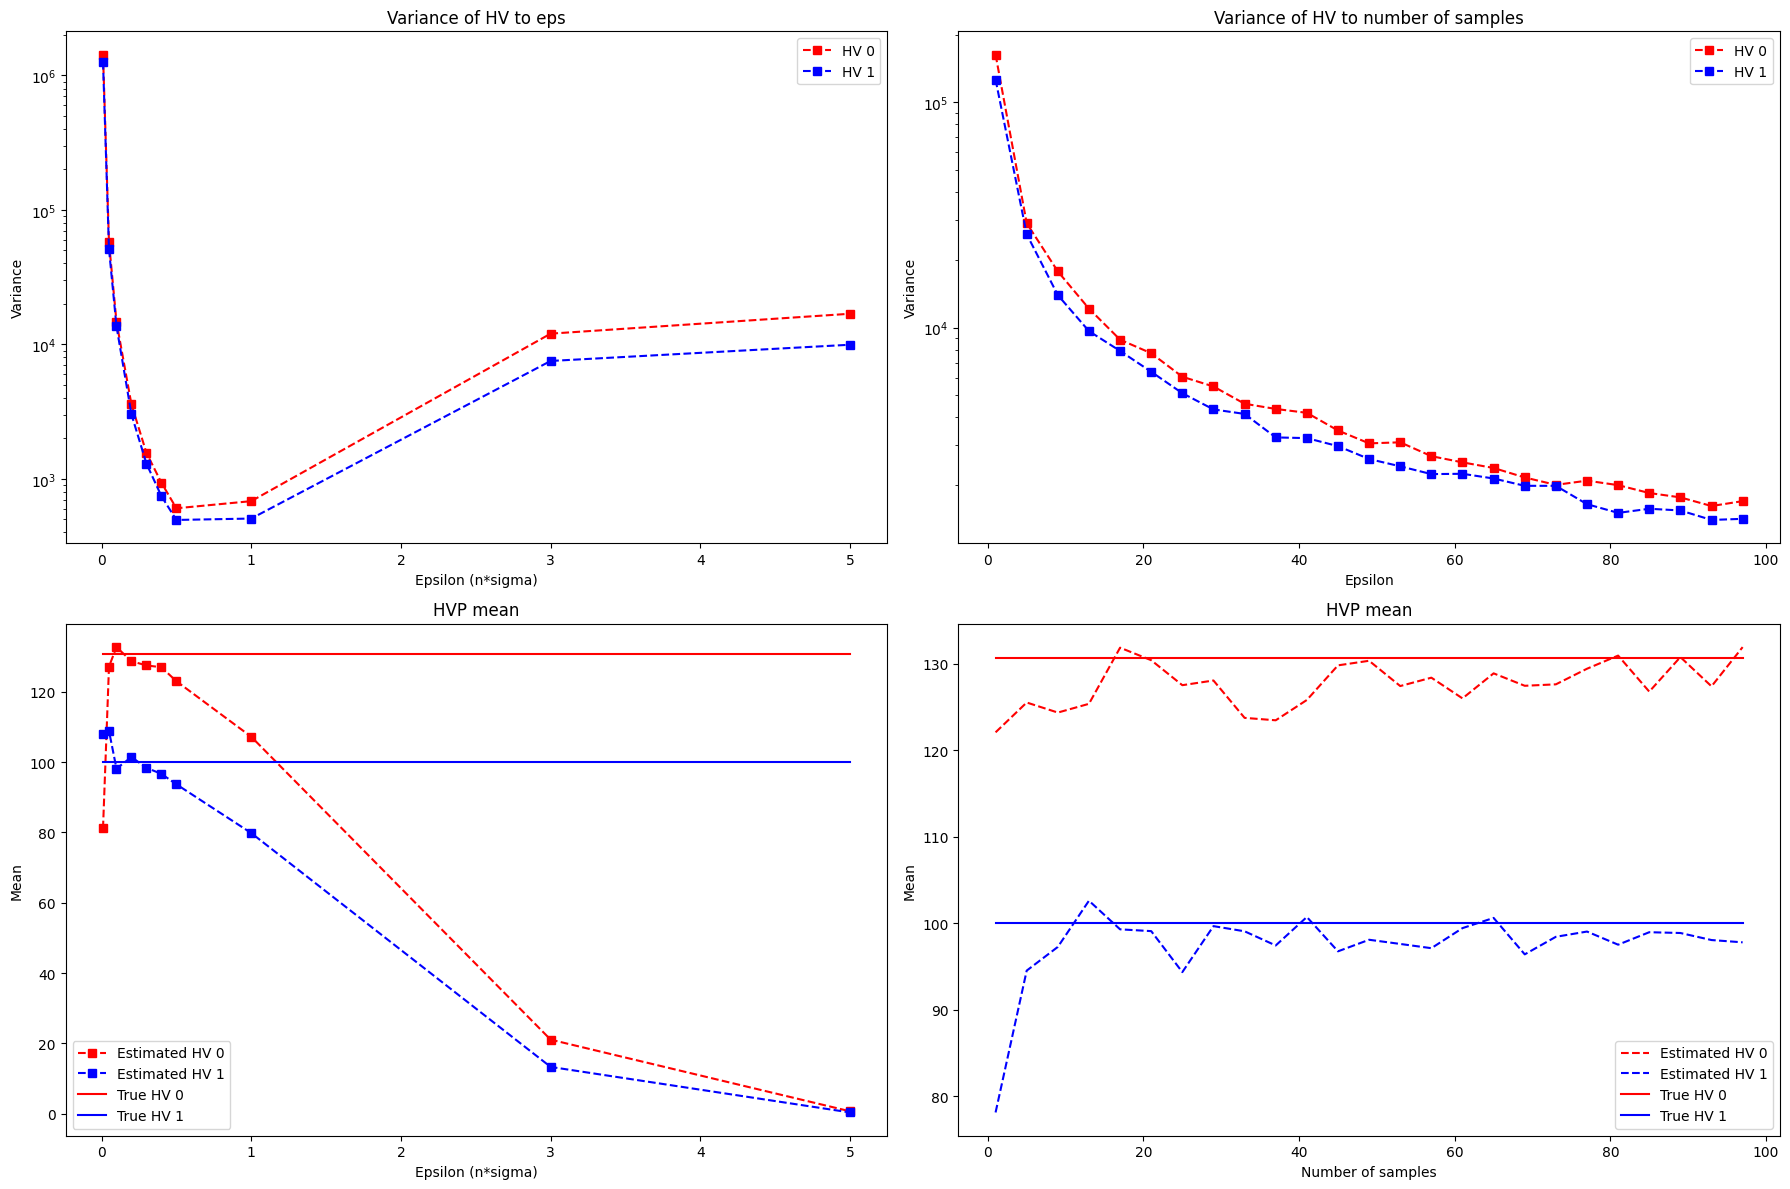

In [345]:
plt.figure(figsize=(18,12))
plt.subplot(2,2,2)
plt.plot(number_of_samples, HV_var[:,0], color='red', linestyle='--', label="HV 0", marker='s')
plt.plot(number_of_samples, HV_var[:,1], color='blue', linestyle='--', label="HV 1", marker='s')
plt.title("Variance of HV to number of samples")
plt.yscale('log')
plt.xlabel("Epsilon")
# plt.ylim(bottom=10)
plt.ylabel("Variance")
plt.legend()

plt.subplot(2,2,1)
plt.plot(epses/sigma2, HV_var_eps[:,0], color='red', linestyle='--', label="HV 0", marker='s')
plt.plot(epses/sigma2, HV_var_eps[:,1], color='blue', linestyle='--', label="HV 1", marker='s')
plt.xlabel("Epsilon (n*sigma)")
plt.ylabel("Variance")
plt.yscale('log')
# plt.xscale('log')
# plt.ylim(bottom=1)
plt.title("Variance of HV to eps")
plt.legend()

plt.subplot(2,2,4)
plt.plot(number_of_samples, HV_mean[:,0], color='red', linestyle='--', label="Estimated HV 0")
plt.plot(number_of_samples, HV_mean[:,1], color='blue', linestyle='--', label="Estimated HV 1")
plt.plot(number_of_samples, true_HV1[:,0], color='red', label="True HV 0")
plt.plot(number_of_samples, true_HV1[:,1], color='blue', label="True HV 1")
plt.plot()
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("HVP mean")
plt.tight_layout()
plt.legend()

plt.subplot(2,2,3)
plt.plot(epses/sigma2, HV_mean_eps[:, 0], color='red', linestyle='--', label="Estimated HV 0", marker='s')
plt.plot(epses/sigma2, HV_mean_eps[:, 1], color='blue', linestyle='--', label="Estimated HV 1", marker='s')
plt.plot(epses/sigma2, true_HV2[:,0], color='red', label="True HV 0")
plt.plot(epses/sigma2, true_HV2[:,1], color='blue', label="True HV 1")
plt.xlabel("Epsilon (n*sigma)")
plt.ylabel("Mean")
# plt.xscale('log')
plt.title("HVP mean")
plt.legend()
plt.tight_layout()
plt.show()


# Example problem on parabola

Text(0.5, 1.0, 'Potential function')

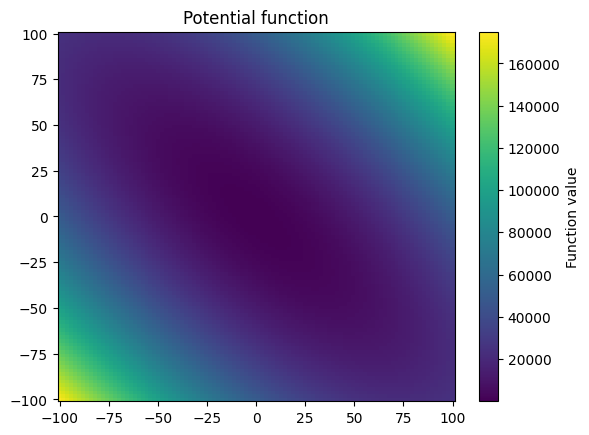

In [140]:
def potential(x, a=1.0, b=1.0, c=1.0):
    '''
    For 2d potential
    x is shape (n, 2)
    '''
    return 0.5*(a*x[:, 0]**2 + b*x[:, 1]**2 + c*x[:, 0]*x[:, 1])

a, b, c = 10, 10, 15

def logging_potential(theta, y_hist, x_hist, i, interval=5, **kwargs):
    y = potential(theta, a, b, c)
    y_hist.append(y.cpu())
    x_hist.append(theta.cpu())

    if (i+1) % interval == 0:
        print("Iteration: {}, y:{}, x:{}".format(i, y, theta))
    return y_hist, x_hist

grid_size = 100
x1 = np.linspace(-100, 100, grid_size)
x2 = np.linspace(-100, 100, grid_size)
X1, X2 = np.meshgrid(x1, x2)
x = np.stack([X1, X2], axis=2).reshape(-1, 2)
y = potential(torch.tensor(x, dtype=torch.float32), a, b, c).reshape((grid_size,grid_size))

pcm = plt.pcolor(X1, X2, y)
cbar = plt.colorbar(pcm)
cbar.set_label('Function value')
plt.title('Potential function')

In [261]:
n_samples = 4
sigma = 0.1

# plt.rcParams['figure.figsize'] = (12, 6)
ctx_args = {'nsamples':n_samples}
# cg_potential_hparams = {'sigma_annealing': False,
#            'epochs': 10000,
#            'tol': 1e-10, # tolerance for CG
#            'NR_max_iter': 200, # max iter for NR line search in CG
#            'NR_tol': 1e-3, # tolerance for NR line search in CG
#            'recompute': 2, # recompute the exact residual every n iterations
#            'TR':False, # use trust region
#            'TR_rate':0.1, # trust region rate
#            'plot_interval':10 # number of iterations to plot
#            }

cg_potential_hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 1000,
           'anneal_const_first': 20,
           'anneal_const_last': 300,
           'anneal_sigma_min': 0.05,
           'tol': 5e-5, # tolerance for CG
           'HVP':True, # using HVP or full hessian
           'TR':True,
           'TR_bound': 50, # number or 'dynamic'
           'NR_max_iter': 5, # max iter for NR line search in CG
           'NR_tol': 1e-3, # tolerance for NR line search in CG
           'recompute': 5, # recompute the exact residual every n iterations
           'conv_thres': 5, # convergence threshold
           'plot_interval':10 # number of iterations to plot
           }
# --------------- run optimization CG
max_iter = cg_potential_hparams['epochs']
theta = torch.tensor([1000.0, -1000.0], device=device)
f_args = {'a': a, 'b': b, 'c': c}
kernel_args = {'sigma': sigma}
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
start_time = time.time()
x, _, _, _= NCG_smooth(potential, theta, max_iter, log_func=logging_potential, f_args=f_args, kernel_args=kernel_args, 
           sampler_args=sampler_args, opt_args=cg_potential_hparams, ctx_args=ctx_args, device=device)
print('Final result: ', x)
print("Time taken: ", time.time()-start_time)


Starting NCG with sigma: 0.100000, TR: True, TR_bound: 50, HVP: True
Iteration: 9, y:tensor([1946023.5000], device='cuda:0'), x:tensor([[ 871.4076, -892.2786]], device='cuda:0')
Iteration: 19, y:tensor([1559603.], device='cuda:0'), x:tensor([[ 791.6362, -788.0069]], device='cuda:0')
Iteration: 29, y:tensor([1124028.], device='cuda:0'), x:tensor([[ 680.1373, -659.8490]], device='cuda:0')
Iteration: 39, y:tensor([793927.], device='cuda:0'), x:tensor([[ 573.5377, -552.1029]], device='cuda:0')
Iteration: 49, y:tensor([552711.7500], device='cuda:0'), x:tensor([[ 478.0498, -461.2981]], device='cuda:0')
Iteration: 59, y:tensor([369339.3750], device='cuda:0'), x:tensor([[ 387.1804, -381.3954]], device='cuda:0')
Iteration: 69, y:tensor([221098.5625], device='cuda:0'), x:tensor([[ 296.7602, -298.0060]], device='cuda:0')
Iteration: 79, y:tensor([103455.5938], device='cuda:0'), x:tensor([[ 205.4572, -201.2424]], device='cuda:0')
Iteration: 89, y:tensor([38286.9141], device='cuda:0'), x:tensor([[ 1

In [291]:

newton_params = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 3000,
           'anneal_const_first': 0,
           'anneal_const_last': 1500,
           'anneal_sigma_min': 0.01,
           'TR':True,
           'TR_bound': 300,
           'TR_rate': 1e6,
           'learning_rate':0.2,
           'conv_thres': 3, # convergence threshold
           'tol': 5e-5, # tolerance for newton
           'hessian mod':True,
           'plot_interval':10 # number of iterations to plot
           }

# --------------- run optimization newton
max_iter = newton_params['epochs']
theta = torch.tensor([1000.0, 1000.0], device=device)
f_args = {'a': a, 'b': b, 'c': c}
kernel_args = {'sigma': sigma}
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
start_time = time.time()
x, _ = newton_smooth(potential, theta, max_iter, log_func=logging_potential, f_args=f_args, kernel_args=kernel_args, 
           sampler_args=sampler_args, opt_args=newton_params, ctx_args=ctx_args, device=device)
print('Final result: ', x)
print("Time taken: ", time.time()-start_time)

Iteration: 9, y:tensor([14357769.], device='cuda:0'), x:tensor([[820.8068, 989.6362]], device='cuda:0')
Iteration: 19, y:tensor([13439679.], device='cuda:0'), x:tensor([[760.9562, 989.6032]], device='cuda:0')
Iteration: 29, y:tensor([12378957.], device='cuda:0'), x:tensor([[702.8955, 976.0380]], device='cuda:0')
Iteration: 39, y:tensor([12378100.], device='cuda:0'), x:tensor([[702.8638, 976.0113]], device='cuda:0')
Iteration: 49, y:tensor([10605558.], device='cuda:0'), x:tensor([[585.3805, 964.9565]], device='cuda:0')
Iteration: 59, y:tensor([10604985.], device='cuda:0'), x:tensor([[585.3445, 964.9493]], device='cuda:0')
Iteration: 69, y:tensor([9071831.], device='cuda:0'), x:tensor([[526.6259, 906.1963]], device='cuda:0')
Iteration: 79, y:tensor([8323837.], device='cuda:0'), x:tensor([[526.5643, 847.4382]], device='cuda:0')
Iteration: 89, y:tensor([8319602.], device='cuda:0'), x:tensor([[526.2231, 847.4164]], device='cuda:0')
Iteration: 99, y:tensor([6008847.], device='cuda:0'), x:ten

In [274]:
# def adam_opt(func, x0, max_iter, log_func, f_args, kernel_args, sampler_args, opt_args, ctx_args, device='cuda'):
#     self_kernel_args = kernel_args.copy()
#     self_sampler_args = sampler_args.copy()
#     optim = torch.optim.Adam([x0], lr=opt_args['learning_rate'])
#     conv_thres = opt_args.get('conv_thres', 10)
#     diff_func = smoothFn_gradient(func=func, sampler='importance_gradgauss', n=ctx_args['nsamples'], f_args=f_args,
#                         kernel_args=self_kernel_args, sampler_args=self_sampler_args, device=device)
#     diff_func_check = smoothFn_gradient(func=func, sampler='importance_gradgauss', n=500, f_args=f_args,
#                         kernel_args=self_kernel_args, sampler_args=self_sampler_args, device=device)
#     img_errors, param_errors = [], []
#     convergence = 0
#     converged = False
#     sigma = self_sampler_args['sigma']
#     for i in range(max_iter):
#         optim.zero_grad()
#         self_kernel_args['sigma'] = sigma
#         self_sampler_args['sigma'] = sigma
#         diff_func = smoothFn_gradient(func=func, sampler='importance_gradgauss', n=n_samples, f_args=f_args,
#                                 kernel_args=self_kernel_args, sampler_args=self_sampler_args, device=device) 
#         x0.grad = diff_func(x0.unsqueeze(0)).squeeze(0)
#         optim.step()
#         img_errors, param_errors = log_func(x0.unsqueeze(0), img_errors, param_errors, i, interval=opt_args['plot_interval'])
#         if torch.norm(diff_func(x0.unsqueeze(0))) < opt_args['tol']:
#             if converged:
#                 convergence += 1
#             else:
#                 convergence = 1
#             converged = True
#             # print(convergence)
#             if convergence >= conv_thres:
#                 if torch.norm(diff_func_check(x0.unsqueeze(0))) < opt_args['tol']:
#                     break
#                 else:
#                     convergence = 0
#         else:
#             converged = False
#         if opt_args.get('sigma_annealing', False):
#             sigma = sigma_scheduler(i, opt_args, sigma)
#     return x0, img_errors, param_errors


In [225]:
n_samples = 4
sigma = 0.1

ctx_args = {'nsamples':n_samples}
adam_params = {'epochs': 20000,
           'learning_rate':0.5,
           'plot_interval':100, # number of iterations to plot
           'tol':5e-5
           }

f_args = {'a': a, 'b': b, 'c': c}
kernel_args = {'sigma': sigma}
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}

# --------------- run optimization Adam
theta = torch.tensor([1000.0, -1000.0], device=device)
start_time = time.time()
x, f_loss, param_loss, iter_time = mi_opt(potential, theta, adam_params['epochs'], log_func=logging_potential, f_args=f_args, kernel_args=kernel_args, 
                                           sampler_args=sampler_args, opt_args=adam_params, ctx_args=ctx_args, device=device)
print('time taken: ', time.time()-start_time)
print('final result: ', x)

Iteration: 99, y:tensor([2298020.5000], device='cuda:0'), x:tensor([[ 958.2671, -959.2379]], device='cuda:0')
Iteration: 199, y:tensor([2117904.5000], device='cuda:0'), x:tensor([[ 919.2252, -921.5921]], device='cuda:0')
Iteration: 299, y:tensor([1954358.5000], device='cuda:0'), x:tensor([[ 883.2855, -885.0336]], device='cuda:0')
Iteration: 399, y:tensor([1768939.], device='cuda:0'), x:tensor([[ 840.8418, -841.5075]], device='cuda:0')
Iteration: 499, y:tensor([1608639.5000], device='cuda:0'), x:tensor([[ 801.9612, -802.3526]], device='cuda:0')
Iteration: 599, y:tensor([1472516.], device='cuda:0'), x:tensor([[ 766.7994, -768.1316]], device='cuda:0')
Iteration: 699, y:tensor([1338639.], device='cuda:0'), x:tensor([[ 731.7713, -731.7253]], device='cuda:0')
Iteration: 799, y:tensor([1208869.7500], device='cuda:0'), x:tensor([[ 694.9885, -695.7622]], device='cuda:0')
Iteration: 899, y:tensor([1084124.], device='cuda:0'), x:tensor([[ 658.6407, -658.4008]], device='cuda:0')
Iteration: 999, y:

In [249]:
n_samples = 4
sigma = 10

ctx_args = {'nsamples':n_samples}
adam_params = {'sigma_annealing': True,
           'sigma': sigma,
           'anneal_const_first': 0,
           'anneal_const_last': 5000,
           'anneal_sigma_min': 0.01,
           'epochs': 20000,
           'learning_rate':0.5,
           'plot_interval':100, # number of iterations to plot
           'tol':5e-5
           }

f_args = {'a': a, 'b': b, 'c': c}
kernel_args = {'sigma': sigma}
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}

# --------------- run optimization Adam
theta = torch.tensor([1000.0, -1000.0], device=device)
start_time = time.time()
x, _, _ = adam_opt(potential, theta, adam_params['epochs'], log_func=logging_potential, f_args=f_args, kernel_args=kernel_args, 
           sampler_args=sampler_args, opt_args=adam_params, ctx_args=ctx_args, device=device)
print('time taken: ', time.time()-start_time)
print('final result: ', x)

Iteration: 99, y:tensor([2287443.], device='cuda:0'), x:tensor([[ 955.7554, -957.3288]], device='cuda:0')
Iteration: 199, y:tensor([2078363.5000], device='cuda:0'), x:tensor([[ 910.6110, -912.9415]], device='cuda:0')
Iteration: 299, y:tensor([1891102.], device='cuda:0'), x:tensor([[ 868.2368, -871.2175]], device='cuda:0')
Iteration: 399, y:tensor([1707776.5000], device='cuda:0'), x:tensor([[ 824.6885, -828.2938]], device='cuda:0')
Iteration: 499, y:tensor([1553066.], device='cuda:0'), x:tensor([[ 786.4900, -789.8435]], device='cuda:0')
Iteration: 599, y:tensor([1401567.], device='cuda:0'), x:tensor([[ 746.1934, -751.2472]], device='cuda:0')
Iteration: 699, y:tensor([1256198.5000], device='cuda:0'), x:tensor([[ 705.8297, -711.7978]], device='cuda:0')
Iteration: 799, y:tensor([1121448.7500], device='cuda:0'), x:tensor([[ 667.2033, -672.2517]], device='cuda:0')
Iteration: 899, y:tensor([1003987.7500], device='cuda:0'), x:tensor([[ 630.9731, -636.3768]], device='cuda:0')
Iteration: 999, y:

In [80]:
# comparison
n_starting_points = 50
starting_points = torch.rand(n_starting_points, 2, device=device)*200 + 800
np.save('./results/quadratic_sp.npy', starting_points.cpu())


In [81]:
ctx_args = {'nsamples':2}
lr_list = [0.5, 0.1, 0.05, 0.01, 1e-3]
time_hist = np.zeros((n_starting_points, 2+len(lr_list)))
loss_hist = np.zeros((n_starting_points, 2+len(lr_list)))


In [308]:
n_samples = 4
sigma = 1

# plt.rcParams['figure.figsize'] = (12, 6)
ctx_args = {'nsamples':n_samples}

cg_potential_hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 5000,
           'anneal_const_first': 0,
           'anneal_const_last': 4500,
           'anneal_sigma_min': 0.01,
           'tol': 5e-5, # tolerance for CG
           'HVP':False, # using HVP or full hessian
           'TR':True,
           'TR_bound': 'dynamic', # number or 'dynamic'
           'NR_max_iter': 200, # max iter for NR line search in CG
           'NR_tol': 1e-3, # tolerance for NR line search in CG
           'recompute': 1, # recompute the exact residual every n iterations
           'conv_thres': 3, # convergence threshold
           'plot_interval':10 # number of iterations to plot
           }
cg_potential_hparams_HVP = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 1000,
           'anneal_const_first': 0,
           'anneal_const_last': 850,
           'anneal_sigma_min': 0.05,
           'tol': 5e-5, # tolerance for CG
           'HVP':True, # using HVP or full hessian
           'TR':True,
           'TR_bound': 50, # number or 'dynamic'
           'NR_max_iter': 5, # max iter for NR line search in CG
           'NR_tol': 1e-3, # tolerance for NR line search in CG
           'recompute': 5, # recompute the exact residual every n iterations
           'conv_thres': 2, # convergence threshold
           'plot_interval':10 # number of iterations to plot
           }
adam_params = {'sigma_annealing': True,
           'sigma': sigma,
           'anneal_const_first': 0,
           'anneal_const_last': 5000,
           'anneal_sigma_min': 0.01,
           'epochs': 20000,
           'learning_rate':0.5,
           'plot_interval':100, # number of iterations to plot
           'tol':5e-5
           }
newton_params = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 4000,
           'anneal_const_first': 0,
           'anneal_const_last': 2800,
           'anneal_sigma_min': 0.01,
           'TR':True,
           'TR_bound': 300,
           'TR_rate': 1e6,
           'learning_rate':0.2,
           'conv_thres': 3, # convergence threshold
           'tol': 5e-5, # tolerance for newton
           'hessian mod':True,
           'plot_interval':10 # number of iterations to plot
           }

starting_points = np.load('./results/quadratic/quadratic_sp.npy')
starting_points = torch.tensor(starting_points, device=device)

In [297]:
for i, theta in enumerate(starting_points):
    print(i)
    
    # --------------- run optimization CG
    # time1 = time.time()
    # x_cg, func_loss, param_loss, time_iters = NCG_smooth(potential, theta, cg_potential_hparams['epochs'], log_func=logging_potential, f_args=f_args, kernel_args=kernel_args, 
    #         sampler_args=sampler_args, opt_args=cg_potential_hparams, ctx_args=ctx_args, device=device)
    # time2 = time.time()
    # time_hist[i, 0] = time2 - time1
    # loss_hist[i, 0] = potential(x_cg, a, b, c)
    # np.save(f'./results/quadratic_cg/quadratic_cg_f_loss_{i}.npy', func_loss)
    # np.save(f'./results/quadratic_cg/quadratic_cg_param_loss_{i}.npy', param_loss)
    # np.save(f'./results/quadratic_cg/quadratic_cg_times_{i}.npy', time_iters)

    # --------------- run optimization CG HVP
    # x_cg2, func_loss, param_loss, time_iters = NCG_smooth(potential, theta.clone(), cg_potential_hparams_HVP['epochs'], log_func=logging_potential, f_args=f_args, kernel_args=kernel_args, 
    #                                                      sampler_args=sampler_args, opt_args=cg_potential_hparams_HVP, ctx_args=ctx_args, device=device)
    # np.save(f'./results/quadratic_cg_HVP/quadratic_cg_HVP_f_loss_{i}.npy', func_loss)
    # np.save(f'./results/quadratic_cg_HVP/quadratic_cg_HVP_param_loss_{i}.npy', param_loss)
    # np.save(f'./results/quadratic_cg_HVP/quadratic_cg_HVP_times_{i}.npy', time_iters)
    
    # --------------- run optimization mi:
    
    # time1 = time.time()
    # x_mi, func_loss, param_loss, time_iters = mi_opt(potential, theta.clone(), adam_params['epochs'], log_func=logging_potential, f_args=f_args, kernel_args=kernel_args, 
    #                                        sampler_args=sampler_args, opt_args=adam_params, ctx_args=ctx_args, device=device)
    # time2 = time.time()
    # time_hist[i, 0] = time2 - time1
    # loss_hist[i, 0] = potential(x_mi.unsqueeze(0), a, b, c)
    # np.save(f'./results/quadratic_mi/quadratic_mi_f_loss_{i}.npy', func_loss)
    # np.save(f'./results/quadratic_mi/quadratic_mi_param_loss_{i}.npy', param_loss)
    # np.save(f'./results/quadratic_mi/quadratic_mi_times_{i}.npy', time_iters)
    
#     # --------------- run optimization newton
    
    x, func_loss, param_loss, time_iters = newton_smooth(potential, theta.clone(), newton_params['epochs'], log_func=logging_potential, f_args=f_args, kernel_args=kernel_args, 
                        sampler_args=sampler_args, opt_args=newton_params, ctx_args=ctx_args, device=device)
    np.save(f'./results/quadratic_newton/quadratic_newton_f_loss_{i}.npy', func_loss)
    np.save(f'./results/quadratic_newton/quadratic_newton_param_loss_{i}.npy', param_loss)
    np.save(f'./results/quadratic_newton/quadratic_newton_times_{i}.npy', time_iters)
    
    
    # # --------------- run optimization Adam
    
    # x, func_loss, param_loss, time_iters = adam_opt(potential, theta, adam_params['epochs'], log_func=logging_potential, f_args=f_args, kernel_args=kernel_args, 
    #         sampler_args=sampler_args, opt_args=adam_params, ctx_args=ctx_args, device=device)
    # np.save(f'./results/quadratic_adam/quadratic_adam_f_loss_{i}.npy', func_loss)
    # np.save(f'./results/quadratic_adam/quadratic_adam_param_loss_{i}.npy', param_loss)
    # np.save(f'./results/quadratic_adam/quadratic_adam_times_{i}.npy', time_iters)
    # for j, lr in enumerate(lr_list):
    #     clear_output(wait=True)
    #     adam_params['learning_rate'] = lr
    #     time3 = time.time()
    #     x_adam, _, _ = adam_opt(potential, theta, adam_params['epochs'], log_func=logging_potential, f_args=f_args, kernel_args=kernel_args,
    #                     sampler_args=sampler_args, opt_args=adam_params, ctx_args=ctx_args, device=device)
    #     time4 = time.time()
    #     loss_hist[i, 2+j] = potential(x_adam.unsqueeze(0), a, b, c)
    #     time_hist[i, 2+j] = time4 - time2
    

0
Iteration: 9, y:tensor([14823060.], device='cuda:0'), x:tensor([[ 839.1330, 1000.5425]], device='cuda:0')
Iteration: 19, y:tensor([14821480.], device='cuda:0'), x:tensor([[ 839.1338, 1000.4449]], device='cuda:0')
Iteration: 29, y:tensor([13864628.], device='cuda:0'), x:tensor([[839.0678, 940.7025]], device='cuda:0')
Iteration: 39, y:tensor([12825010.], device='cuda:0'), x:tensor([[780.0616, 931.1283]], device='cuda:0')
Iteration: 49, y:tensor([11109195.], device='cuda:0'), x:tensor([[720.7230, 871.7549]], device='cuda:0')
Iteration: 59, y:tensor([9982930.], device='cuda:0'), x:tensor([[688.0231, 821.6986]], device='cuda:0')
Iteration: 69, y:tensor([9981826.], device='cuda:0'), x:tensor([[688.0073, 821.6315]], device='cuda:0')
Iteration: 79, y:tensor([9981034.], device='cuda:0'), x:tensor([[687.9672, 821.6115]], device='cuda:0')
Iteration: 89, y:tensor([8051003.], device='cuda:0'), x:tensor([[707.5233, 648.8459]], device='cuda:0')
Iteration: 99, y:tensor([6717167.], device='cuda:0'), 

Cg average time: 6.287426710128784
Cg average time for 0.1 percentile in function loss: 1.8078857779502868
Cg average time for 0.1 percentile in parameter loss: 2.3825623750686646
Cg average time for 0.01 percentile in function loss: 2.3938321828842164
Cg average time for 0.01 percentile in parameter loss: 2.557828736305237
Cg average time for 0.001 percentile in function loss: 2.570742654800415
Cg average time for 0.001 percentile in parameter loss: 2.61399964094162
PRDPT average time: 15.659385645389557
PRDPT average time for 0.1 percentile in function loss: 2.7672046661376952
PRDPT average time for 0.1 percentile in parameter loss: 4.448753905296326
PRDPT average time for 0.01 percentile in function loss: 4.861761856079101
PRDPT average time for 0.01 percentile in parameter loss: 7.010750138759613
PRDPT average time for 0.001 percentile in function loss: 6.6697528719902035
PRDPT average time for 0.001 percentile in parameter loss: 8.696660196781158
Adam average time: 33.400738215446

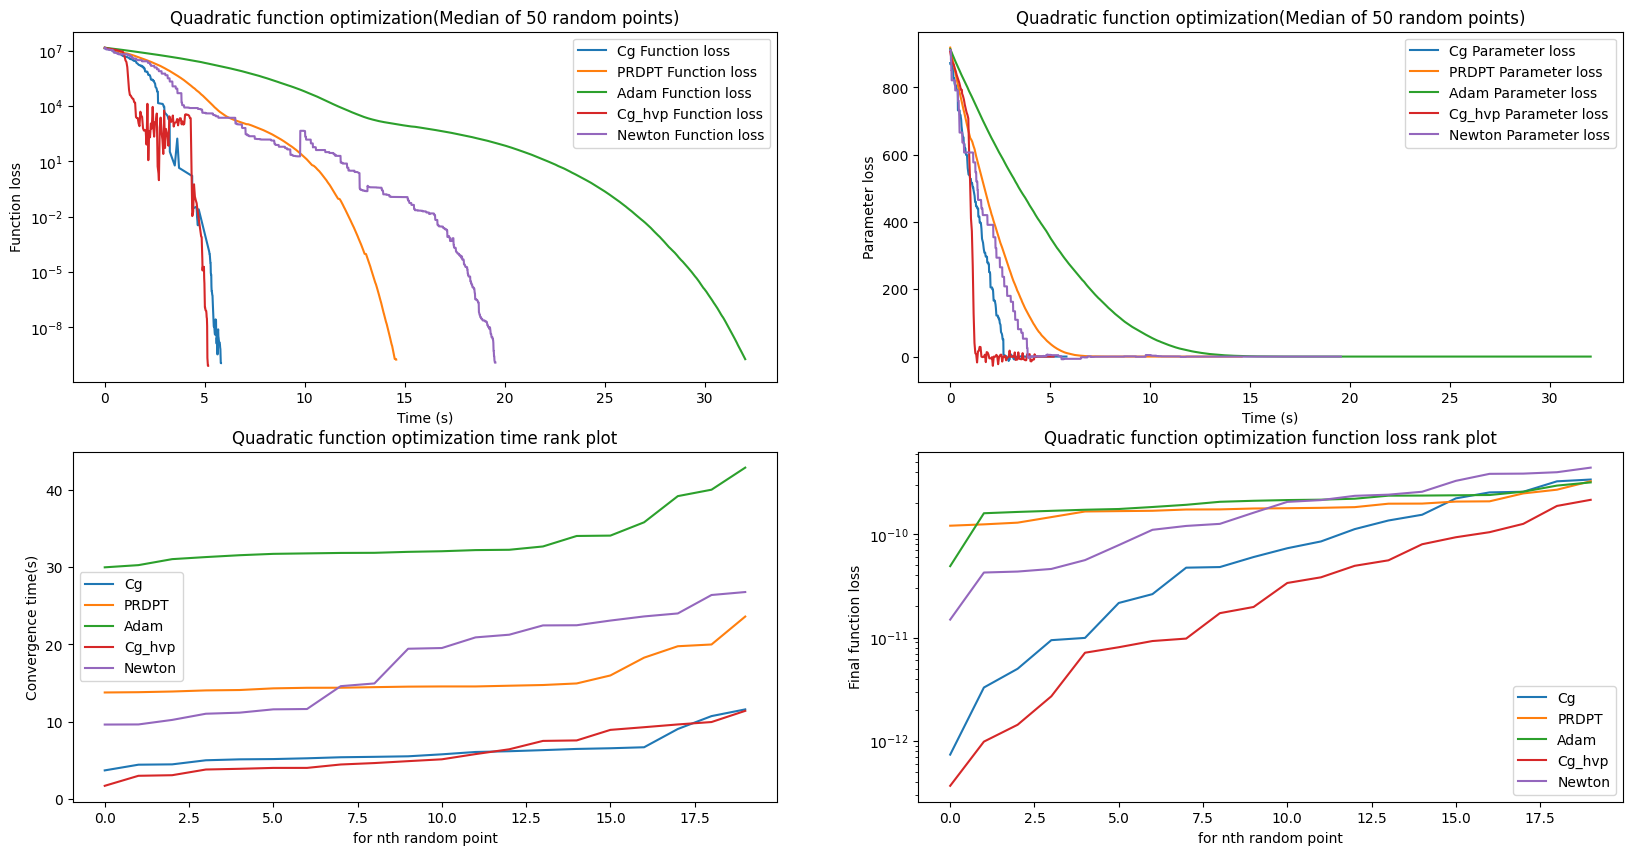

In [685]:
# np.save('potential_loss_hist.npy', loss_hist)
# np.save('potential_time_hist.npy', time_hist)

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
task = 'quadratic'
path = './results/' + task + '/'
opts = ['cg', 'mi', 'adam', 'cg_HVP', 'newton']
percentiles = [0.1, 0.01, 1e-3]

final_times = {'final_times_cg':[],
                'final_times_mi': [],
                'final_times_adam': [],
                'final_times_cg_HVP': [],
                'final_times_newton': []
                }
final_conv = {'final_conv_cg':[],
            'final_conv_mi': [],
            'final_conv_adam': [],
            'final_conv_cg_HVP': [],
            'final_conv_newton': []
            }

mean_final_times = np.zeros((len(opts), n_starting_points))
mean_f_percentile_times = np.zeros((len(opts), len(percentiles), n_starting_points))
mean_param_percentile_times = np.zeros((len(opts), len(percentiles), n_starting_points))

for i in range(n_starting_points):
    for j in range(len(opts)):
        iter_times = np.load(path + task + '_' + opts[j] + '/' + task + '_' + opts[j] + f'_times_{i}.npy')
        f_loss = np.load(path + task + '_' + opts[j] + '/' + task + '_' + opts[j] + f'_f_loss_{i}.npy')
        param_loss = np.load(path + task + '_' + opts[j] + '/' + task + '_' + opts[j] + f'_param_loss_{i}.npy')
        times = np.cumsum(iter_times)
        
        final_times['final_times_'+opts[j]].append(times[-1])
        final_conv['final_conv_'+opts[j]].append([f_loss[-1].squeeze(), param_loss[-1].squeeze().mean()])
        mean_final_times[j, i] = times[-1] 
        # for percentile time
        for l, percentile in enumerate(percentiles):
            initial_f_error = f_loss[0].squeeze()
            initial_param_error = param_loss[0].squeeze().mean()
            for k, f_error in enumerate(f_loss):
                if f_error <= initial_f_error*percentile:
                    mean_f_percentile_times[j, l, i] = times[k]
                    break
            for k, param_error in enumerate(param_loss.squeeze().mean(axis=1)):
                if param_error <= initial_param_error*percentile:
                    mean_param_percentile_times[j, l, i] = times[k]
                    break
        

mean_final_times = mean_final_times.mean(axis=1)
mean_f_percentile_times = mean_f_percentile_times.mean(axis=2)
mean_param_percentile_times = mean_param_percentile_times.mean(axis=2)
# print(mean_final_times)
    
for i in range(len(opts)):
    median_id = np.argsort(final_times['final_times_'+opts[i]])[len(final_times['final_times_'+opts[i]])//2]
    sorted_conv = np.sort(final_conv['final_conv_'+opts[i]], axis=0)
    sorted_time = np.sort(final_times['final_times_'+opts[i]])
    
    iter_times = np.load(path + task + '_' + opts[i] + '/' + task + '_' + opts[i] + f'_times_{median_id}.npy')
    f_loss = np.load(path + task + '_' + opts[i] + '/' + task + '_' + opts[i] + f'_f_loss_{median_id}.npy')
    param_loss = np.load(path + task + '_' + opts[i] + '/' + task + '_' + opts[i] + f'_param_loss_{median_id}.npy')
    times = np.cumsum(iter_times)
    label_prefix = opts[i].capitalize()
    if opts[i] == 'mi':
        label_prefix = 'PRDPT'
        
    print(f'{label_prefix} average time: {mean_final_times[i]}')
    for j in range(len(percentiles)):
        print(f'{label_prefix} average time for {percentiles[j]} percentile in function loss: {mean_f_percentile_times[i, j]}')
        print(f'{label_prefix} average time for {percentiles[j]} percentile in parameter loss: {mean_param_percentile_times[i, j]}')
    
    ax[0,0].plot(times, f_loss, label=label_prefix + ' Function loss')
    ax[0,1].plot(times, param_loss.squeeze().mean(axis=1), label=label_prefix+' Parameter loss')
    ax[1,0].plot(sorted_time, label=label_prefix)
    ax[1,1].plot(sorted_conv[:,0], label=label_prefix)
    
ax[1,0].set_xlabel('for nth random point')
ax[1,0].set_ylabel('Convergence time(s)')
ax[1,0].set_title('Quadratic function optimization time rank plot')
ax[1,0].legend()

ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('for nth random point')
ax[1,1].set_ylabel('Final function loss')
ax[1,1].set_title('Quadratic function optimization function loss rank plot')
ax[1,1].legend()

ax[0,0].legend()
ax[0,1].legend()
ax[0,0].set_yscale('log')
# ax[0,1].set_yscale('log')
ax[0,0].set_xlabel('Time (s)')
ax[0,0].set_ylabel('Function loss')
ax[0,0].set_title('Quadratic function optimization(Median of 50 random points)')
ax[0,1].set_xlabel('Time (s)')
ax[0,1].set_ylabel('Parameter loss')
ax[0,1].set_title('Quadratic function optimization(Median of 50 random points)')
plt.savefig('./results/quadratic/Quadratic_task.pdf', format='pdf')

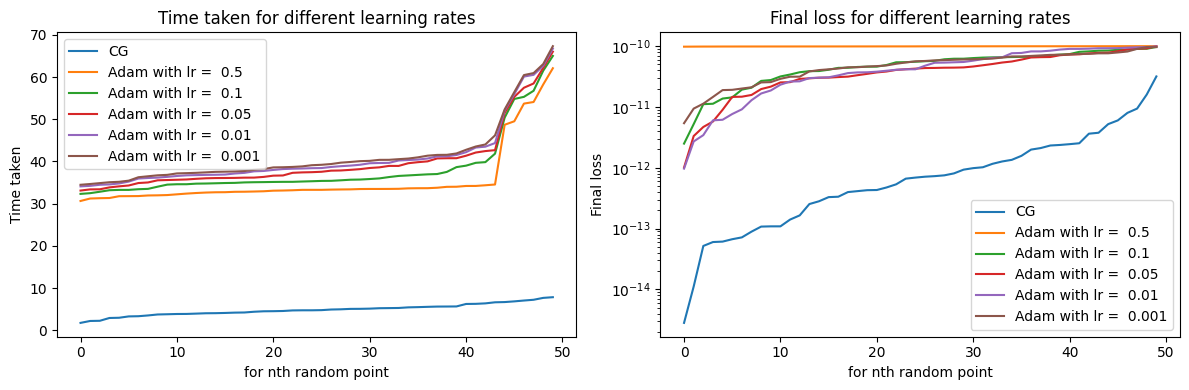

In [132]:
# Draw time plot and loss plot
loss_hist = np.sort(loss_hist, axis=0)
time_hist = np.sort(time_hist, axis=0)
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(time_hist[:, 0], label='CG')
for i, lr in enumerate(lr_list):
    plt.plot(time_hist[:, 2+i], label='Adam with lr =  {}'.format(lr))
plt.xlabel('for nth random point')
plt.ylabel('Time taken')
plt.title('Time taken for different learning rates')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss_hist[:, 0], label='CG')
for i, lr in enumerate(lr_list):
    plt.plot(loss_hist[:, 2+i], label='Adam with lr =  {}'.format(lr))
plt.xlabel('for nth random point')
plt.ylabel('Final loss')
plt.yscale('log')
plt.title('Final loss for different learning rates')
plt.legend()
plt.tight_layout()


# Example problem on box 2D

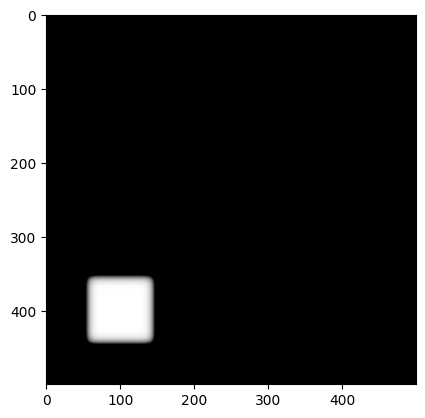

In [519]:
# From Michael's code box example
def get_rendering(theta, update_fn=None, ctx_args=None): 
  return draw_rect(theta[0], theta[1])


def draw_rect_old(px, py):   
  s, w, h, exp = 128, 0.2, 0.2, 10
  px = max(0+h, min(1-h, px))
  py = max(0+w, min(1-w, py))
  ss = torch.linspace(0, 1, s, device=device)
  x, y = torch.meshgrid(ss, ss)
  image = 1 - 2*(abs(((py - x)/w))**exp + abs((y - px)/h)**exp)
  return torch.flipud(image.clamp(0, 1)).unsqueeze(-1)

scale = 500
def draw_rect(px, py):   
  s, exp = scale, 10
  w, h = 0.1*s, 0.1*s
  px = max(0+h, min(s-h, px))
  py = max(0+w, min(s-w, py))
  ss = torch.arange(s, device=device)
  x, y = torch.meshgrid(ss, ss)
  image = 1 - 2*(abs(((py - x)/w))**exp + abs((y - px)/h)**exp)
  return torch.flipud(image.clamp(0, 1)).unsqueeze(-1)

plt.imshow(draw_rect(100, 100).cpu().numpy().squeeze(), cmap='gray')

def render_smooth(perturbed_theta, gt_img):
  '''
  Michael's code but without the average image
  '''
  with torch.no_grad():
      imgs, losses = [], []
      for j in range(perturbed_theta.shape[0]):       # for each sample
          perturbed_img = get_rendering(perturbed_theta[j, :])
          perturbed_loss = torch.nn.MSELoss()(perturbed_img, gt_img)
          imgs.append(perturbed_img)
          losses.append(perturbed_loss)
      loss = torch.stack(losses)
  return loss

def logging_box(theta, img_errors, param_errors, i, interval=5, **f_args):
    # plotting, logging, printing...
    theta = theta.squeeze()
    img_curr = get_rendering(theta)
    img_loss = torch.nn.MSELoss()(img_curr, ref_img).item()
    param_loss = torch.nn.MSELoss()(theta, gt_theta).item()
    img_errors.append(img_loss)
    param_errors.append(param_loss)
    
    print(f"Iter {i+1} - Img.Loss: {img_loss:.4f} - Param.Loss: {param_loss:.4f}")
    if (i+1) % interval == 0: 
        clear_output(wait=True)
        show_with_error(img_curr, ref_img, iter=i+1)
        plt_errors(img_errors, param_errors, title=f'Iter {i+1}')
    return img_errors, param_errors

n_samples = 10
sigma = 0.1

torch.manual_seed(0)
# set up initial and gt translation:
theta = torch.tensor([0.5, 0.6], requires_grad=True, device=device)*scale
gt_theta = torch.tensor([0.3, 0.33], device=device)*scale

init_img = get_rendering(theta)
ref_img = get_rendering(gt_theta)


## IS MSE

In [29]:
min_sample = 1
add_sample = 10
sigma = 0.1
x = torch.tensor([0.5, 0.4], requires_grad=True, device=device)
number_of_samples = np.arange(min_sample, min_sample+add_sample, 1)
n = 100
hess_conv_var = np.zeros((add_sample, 2, 2))
hess_conv_mean = np.zeros((add_sample, 2, 2))
grad_conv_var = np.zeros((add_sample, 2))
grad_conv_mean = np.zeros((add_sample, 2))
for i in range(add_sample):
    print("Number of samples: ", number_of_samples[i])
    ctx_args = {'antithetic': True, 'nsamples': number_of_samples[i], 'sigma': sigma,
                'sampler': sampler, 'device': device, 'gt_image': ref_img, 'update_fn': None}
    hess_conv = np.zeros((n,2,2))
    grad_conv = np.zeros((n,2))
    start_time = time.time()
    for j in range(n):
        f_args = {'gt_img': ref_img}
        kernel_args = {'sigma': sigma}
        sampler = 'importance_hessgauss'
        sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
        hess_func = smoothFn_hessian(func=render_smooth, sampler=sampler, n=number_of_samples[i], f_args=f_args,
                                            kernel_args=kernel_args, sampler_args=sampler_args, device=device)
        hess_conv[j,:,:] = hess_func(x.unsqueeze(0)).cpu().detach().numpy()  

        sampler = 'importance_gradgauss'
        grad_func = smoothFn_gradient(func=render_smooth, sampler=sampler, n=number_of_samples[i], f_args=f_args,
                                            kernel_args=kernel_args, sampler_args=sampler_args, device=device) 
        grad_conv[j,:] = grad_func(x.unsqueeze(0)).cpu().detach().numpy()  
    print("Time taken: ", time.time()-start_time)
    hess_conv_var[i, :, :] = np.var(hess_conv, axis=0)
    hess_conv_mean[i, :, :] = np.mean(hess_conv, axis=0)
    grad_conv_var[i,:] = np.var(grad_conv, axis=0)
    grad_conv_mean[i,:] = np.mean(grad_conv, axis=0)


Number of samples:  1
Time taken:  1.0643837451934814
Number of samples:  2
Time taken:  1.2367596626281738
Number of samples:  3
Time taken:  1.459930181503296
Number of samples:  4
Time taken:  1.6915771961212158
Number of samples:  5
Time taken:  1.9336895942687988
Number of samples:  6
Time taken:  2.163804054260254
Number of samples:  7
Time taken:  2.392087697982788
Number of samples:  8
Time taken:  2.6130404472351074
Number of samples:  9
Time taken:  2.855545997619629
Number of samples:  10
Time taken:  3.082075357437134


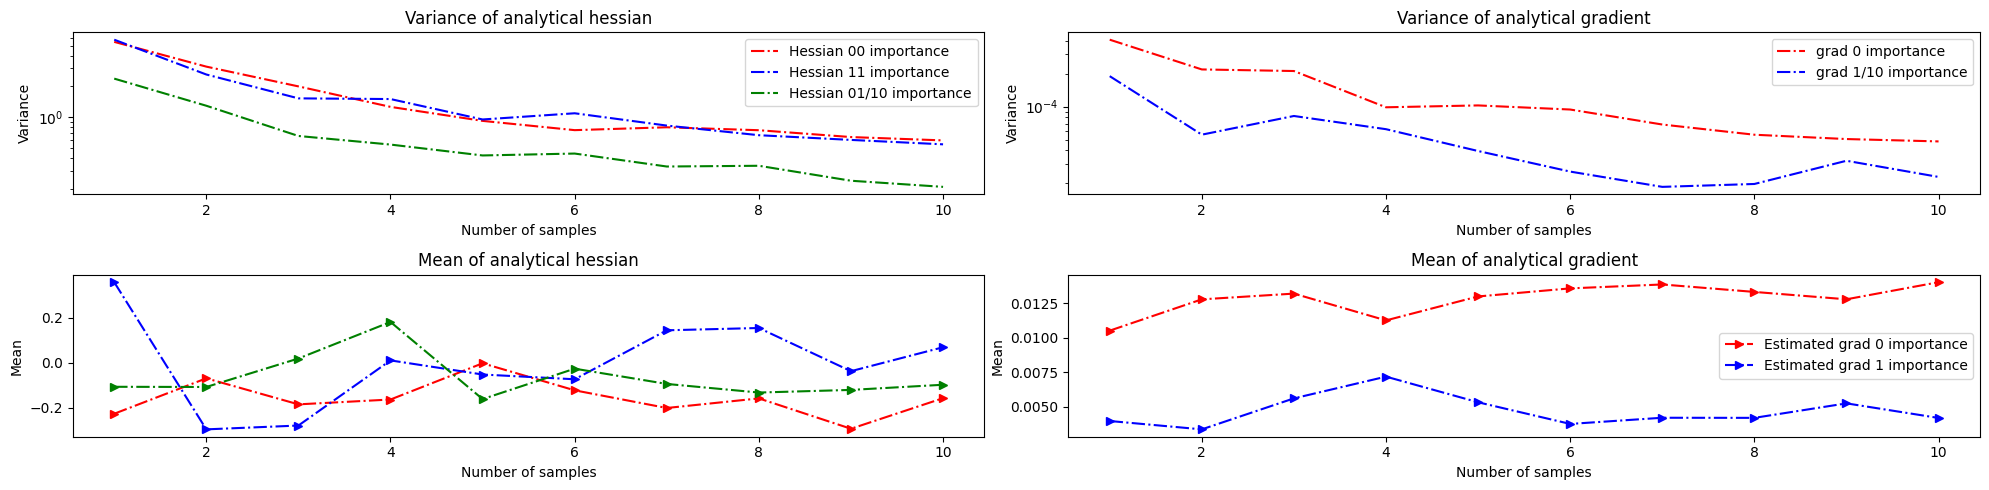

In [30]:
plt.figure(figsize=(20,5))
plt.subplot(2,2,1)
plt.plot(number_of_samples, hess_conv_var[:,0,0], color='red', linestyle='-.', label="Hessian 00 importance")
plt.plot(number_of_samples, hess_conv_var[:,1,1], color='blue', linestyle='-.', label="Hessian 11 importance")
plt.plot(number_of_samples, hess_conv_var[:,0,1], color='green', linestyle='-.', label="Hessian 01/10 importance")
plt.title("Variance of analytical hessian")
plt.xlabel("Number of samples")
plt.yscale('log')
plt.ylabel("Variance")
plt.legend()

plt.subplot(2,2,2)
plt.plot(number_of_samples, grad_conv_var[:,0], color='red', linestyle='-.', label="grad 0 importance")
plt.plot(number_of_samples, grad_conv_var[:,1], color='blue', linestyle='-.', label="grad 1/10 importance")
plt.title("Variance of analytical gradient")
plt.xlabel("Number of samples")
plt.yscale('log')
plt.ylabel("Variance")
plt.legend()

plt.subplot(2,2,3)
plt.plot(number_of_samples, hess_conv_mean[:,0,0], color='red', linestyle='-.', marker='>', label="Estimated hessian 00 importance")
plt.plot(number_of_samples, hess_conv_mean[:,1,1], color='blue', linestyle='-.', marker='>', label="Estimated hessian 11 importance")
plt.plot(number_of_samples, hess_conv_mean[:,1,0], color='green', linestyle='-.', marker='>', label="Estimated hessian 10/01 importance")
plt.plot()
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("Mean of analytical hessian")

plt.subplot(2,2,4)
plt.plot(number_of_samples, grad_conv_mean[:,0], color='red', linestyle='-.', marker='>', label="Estimated grad 0 importance")
plt.plot(number_of_samples, grad_conv_mean[:,1], color='blue', linestyle='-.', marker='>', label="Estimated grad 1 importance")
plt.plot()
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("Mean of analytical gradient")
plt.tight_layout()
plt.legend()


## Individual tests

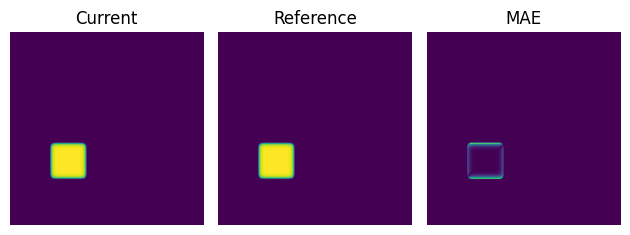

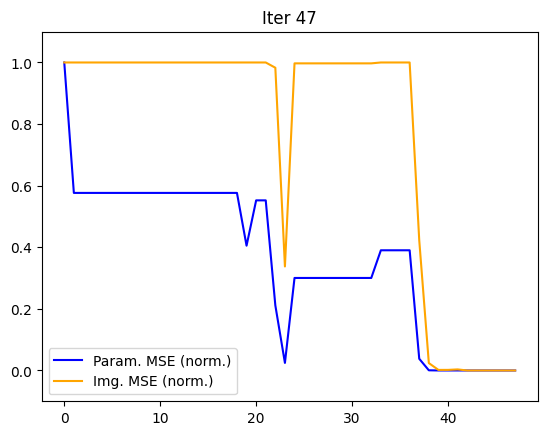

In [523]:
# CG
n_samples = 6
sigma = scale/6
ctx_args = {'nsamples':n_samples}
hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 500,
           'anneal_const_first': 0,
           'anneal_const_last': 20,
           'anneal_sigma_min': 0.1,
           'tol': 1e-4, # tolerance for CG
           'TR':True,
           'HVP':True,
           'TR_bound': 2,
           'NR_max_iter': 10, # max iter for NR line search in CG
           'NR_tol': 1e-3, # tolerance for NR line search in CG
           'recompute': 30, # recompute the exact residual every n iterations
           'conv_thres': 2, # convergence threshold
           'plot_interval':100 # number of iterations to plot
           }


# --------------- run optimization CG
max_iter = hparams['epochs']
theta = torch.tensor([0.5, 0.66], requires_grad=True, device=device)*scale
show_with_error(init_img, ref_img, iter=0)
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler = 'importance_hessgauss'
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
x, _, _, _ = NCG_smooth(render_smooth, theta, max_iter, log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
           sampler_args=sampler_args, opt_args=hparams, ctx_args=ctx_args, device=device)
# print(x_list)

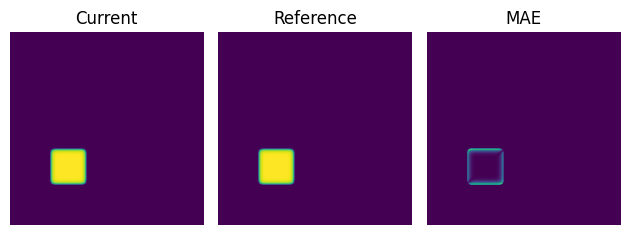

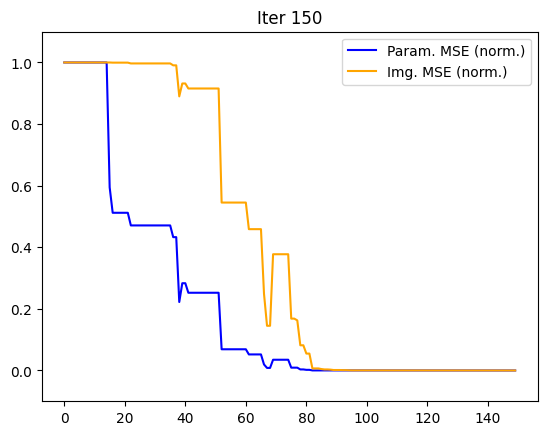

Iter 151 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 152 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 153 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 154 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 155 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 156 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 157 - Img.Loss: 0.0000 - Param.Loss: 0.0000
converged at:  157


(tensor([[149.9996, 150.0009]], device='cuda:0', grad_fn=<SubBackward0>),
 [0.05200887471437454,
  0.05200887471437454,
  0.05200887471437454,
  0.05200887471437454,
  0.05200887471437454,
  0.05200887471437454,
  0.05200887471437454,
  0.052008870989084244,
  0.05200887471437454,
  0.05200887471437454,
  0.052008867263793945,
  0.05200887471437454,
  0.05200887471437454,
  0.05200887471437454,
  0.05200887471437454,
  0.052008338272571564,
  0.05198182165622711,
  0.05198181793093681,
  0.051981814205646515,
  0.05198180302977562,
  0.05198180302977562,
  0.05198179930448532,
  0.051847610622644424,
  0.05184760317206383,
  0.05184759199619293,
  0.05184758082032204,
  0.05184757336974144,
  0.051847562193870544,
  0.05184754729270935,
  0.051847536116838455,
  0.05184752121567726,
  0.051847513765096664,
  0.05184750631451607,
  0.05184749886393547,
  0.05184748396277428,
  0.05184747651219368,
  0.051525987684726715,
  0.05152595788240433,
  0.04628762602806091,
  0.0484617762267589

In [589]:
# newton
n_samples = 6
sigma = scale/6
ctx_args = {'nsamples':n_samples}
newton_params = {'sigma_annealing': True,
                'sigma': sigma,
                'epochs': 1000,
                'anneal_const_first': 0,
                'anneal_const_last': 500,
                'anneal_sigma_min': 0.01,
                'TR':True,
                'TR_bound': 100,
                'TR_rate': 0.1,
                'learning_rate':0.5,
                'conv_thres': 3, # convergence threshold
                'tol': 1e-8, # tolerance for newton
                'hessian mod':True,
                'plot_interval':10 # number of iterations to plot
                }


# --------------- run optimization
max_iter = newton_params['epochs']
theta = torch.tensor([0.5, 0.56], requires_grad=True, device=device)*scale
show_with_error(init_img, ref_img, iter=0)
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
newton_smooth(render_smooth, theta, max_iter, log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
           sampler_args=sampler_args, opt_args=newton_params, ctx_args=ctx_args, device=device)


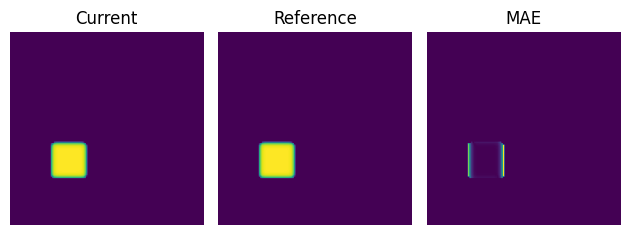

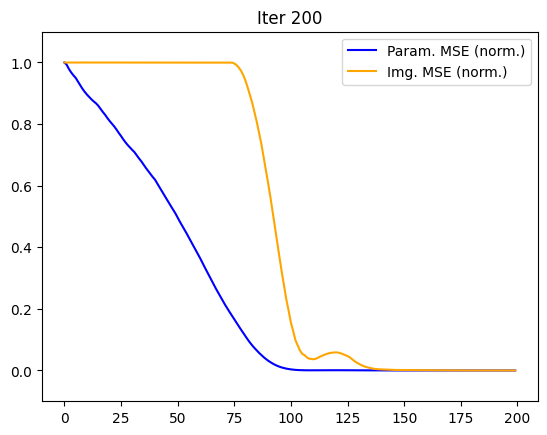

Iter 201 - Img.Loss: 0.0000 - Param.Loss: 0.0006
Iter 202 - Img.Loss: 0.0000 - Param.Loss: 0.0006
Iter 203 - Img.Loss: 0.0000 - Param.Loss: 0.0005
Iter 204 - Img.Loss: 0.0000 - Param.Loss: 0.0004
Iter 205 - Img.Loss: 0.0000 - Param.Loss: 0.0003
Iter 206 - Img.Loss: 0.0000 - Param.Loss: 0.0003
Iter 207 - Img.Loss: 0.0000 - Param.Loss: 0.0002
Iter 208 - Img.Loss: 0.0000 - Param.Loss: 0.0002
Iter 209 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 210 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 211 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 212 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 213 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 214 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 215 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 216 - Img.Loss: 0.0000 - Param.Loss: 0.0001


In [8]:
# adam
ctx_args = {'nsamples':n_samples}
adam_box_params = {'epochs': 1000,
           'learning_rate':5e-1,
           'plot_interval':100, # number of iterations to plot
           'tol':1e-6
           }

# --------------- run optimization Adam
max_iter = hparams['epochs']
theta = torch.tensor([0.7, 0.7], device=device)*128
show_with_error(init_img, ref_img, iter=0)
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler = 'importance_hessgauss'
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
x_adam, _, _ = adam_opt(render_smooth, theta, adam_box_params['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args,
                sampler_args=sampler_args, opt_args=adam_box_params, ctx_args=ctx_args, device=device)

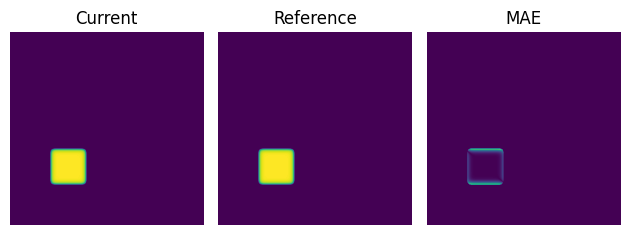

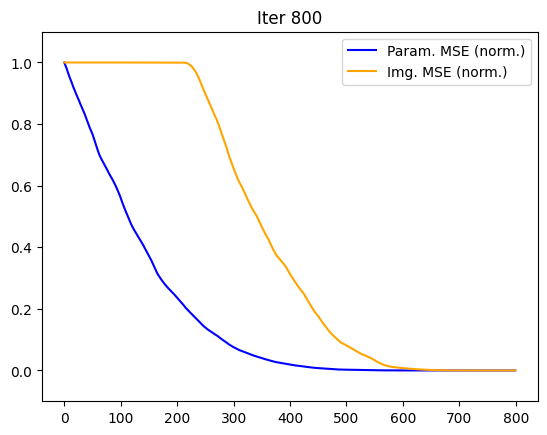

Iter 801 - Img.Loss: 0.0000 - Param.Loss: 0.0005
Iter 802 - Img.Loss: 0.0000 - Param.Loss: 0.0005
Iter 803 - Img.Loss: 0.0000 - Param.Loss: 0.0005
Iter 804 - Img.Loss: 0.0000 - Param.Loss: 0.0004
Iter 805 - Img.Loss: 0.0000 - Param.Loss: 0.0004
Iter 806 - Img.Loss: 0.0000 - Param.Loss: 0.0004
Iter 807 - Img.Loss: 0.0000 - Param.Loss: 0.0004
Iter 808 - Img.Loss: 0.0000 - Param.Loss: 0.0004
Iter 809 - Img.Loss: 0.0000 - Param.Loss: 0.0003
Iter 810 - Img.Loss: 0.0000 - Param.Loss: 0.0003
Iter 811 - Img.Loss: 0.0000 - Param.Loss: 0.0003
Iter 812 - Img.Loss: 0.0000 - Param.Loss: 0.0003
Iter 813 - Img.Loss: 0.0000 - Param.Loss: 0.0003
Iter 814 - Img.Loss: 0.0000 - Param.Loss: 0.0002
Iter 815 - Img.Loss: 0.0000 - Param.Loss: 0.0002
Iter 816 - Img.Loss: 0.0000 - Param.Loss: 0.0002
Iter 817 - Img.Loss: 0.0000 - Param.Loss: 0.0002
Iter 818 - Img.Loss: 0.0000 - Param.Loss: 0.0002
Iter 819 - Img.Loss: 0.0000 - Param.Loss: 0.0002
Iter 820 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 821 - Img.Loss:

In [446]:
# mi
n_samples = 6
sigma = scale/6
ctx_args = {'nsamples':n_samples}


theta = torch.tensor([0.5, 0.66], device=device)*scale
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}

mi_box2_params = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 5000,
           'anneal_const_first': 0,
           'anneal_const_last': 0,
           'anneal_sigma_min': 0.1,
           'learning_rate':0.5,
           'plot_interval':100, # number of iterations to plot
           'conv_thres': 5, # convergence threshold
           'tol':1e-8
           }

logging_box(theta.clone(), [], [], 0, 1)

# --------------- run optimization Adam
x, f_loss, param_loss, iter_time = mi_opt(render_smooth, theta, mi_box2_params['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
                                           sampler_args=sampler_args, opt_args=mi_box2_params, ctx_args=ctx_args, device=device)

## batch test

In [494]:
n_starting_points = 20
starting_points = (torch.rand(n_starting_points, 2, device=device)*0.3 + 0.42)*scale
box_time_hist = np.zeros((n_starting_points, 4+len(lr_list))) # 1 for CG, 1 for Newton, 1 for michale, 1 for BFGS, lr for adam
box_loss_hist = np.zeros((n_starting_points, 4+len(lr_list)))
np.save('./results/box_2param/box_sp.npy', starting_points.cpu())

In [678]:
# comparison
def log_none(*args, **kargs):
    return [],[]

gt_theta = torch.tensor([0.3, 0.3 ], device=device)*scale
ref_img = get_rendering(gt_theta)

# n_samples = 6
# sigma = 35
# ctx_args = {'nsamples':n_samples}
# cg_box_hparams = {'sigma_annealing': True,
#            'sigma': sigma,
#            'epochs': 500,
#            'anneal_const_first': 10,
#            'anneal_const_last': 410,
#            'anneal_sigma_min': 0.05,
#            'tol': 5e-5, # tolerance for CG
#            'TR':True,
#            'TR_bound': 20,
#            'TR_rate': 0.5,
#            'NR_max_iter': 300, # max iter for NR line search in CG
#            'NR_tol': 1e-3, # tolerance for NR line search in CG
#            'recompute': 1, # recompute the exact residual every n iterations
#            'conv_thres': 5, # convergence threshold
#            'plot_interval':100 # number of iterations to plot
        #    }
n_samples = 6
sigma = scale/5
ctx_args = {'nsamples':n_samples}
cg_box_hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 150,
           'anneal_const_first': 15,
           'anneal_const_last': 50,
           'anneal_sigma_min': 1e-4,
           'tol': 5e-5, # tolerance for CG
           'TR':True,
           'HVP':False,
           'TR_bound': 2,
           'NR_max_iter': 10, # max iter for NR line search in CG
           'NR_tol': 1e-3, # tolerance for NR line search in CG
           'recompute': 10, # recompute the exact residual every n iterations
           'conv_thres': 3, # convergence threshold
           'plot_interval':10 # number of iterations to plot
           }
# cg_box_hparams = {'sigma_annealing': True,
#            'sigma': sigma,
#            'epochs': 500,
#            'anneal_const_first': 0,
#            'anneal_const_last': 15,
#            'anneal_sigma_min': 0.01,
#            'tol': 1e-4, # tolerance for CG
#            'TR':True,
#            'HVP':True,
#            'TR_bound': 2,
#            'NR_max_iter': 2, # max iter for NR line search in CG
#            'NR_tol': 1e-3, # tolerance for NR line search in CG
#            'recompute': 10, # recompute the exact residual every n iterations
#            'conv_thres': 2, # convergence threshold
#            'plot_interval':10 # number of iterations to plot
#            }


newton_box_params = {'sigma_annealing': True,
                'sigma': sigma,
                'epochs': 700,
                'anneal_const_first': 100,
                'anneal_const_last': 400,
                'anneal_sigma_min': 0.01,
                'TR':True,
                'TR_bound': sigma,
                'TR_rate': 0.2,
                'learning_rate':0.5,
                'conv_thres': 5, # convergence threshold
                'tol': 9e-8, # tolerance for newton
                'hessian mod':True,
                'plot_interval':10 # number of iterations to plot
                }


adam_box_params = {'sigma_annealing': True,
           'sigma': sigma,
           'anneal_const_first': 0,
           'anneal_const_last': 0,
           'anneal_sigma_min': 0.01,
           'conv_thres': 10, # convergence threshold
           'epochs': 3000,
           'learning_rate':3e-1,
           'plot_interval':1000, # number of iterations to plot
           'tol':5e-8
           }

BFGS_box_params = {'sigma_annealing': True,
               'sigma': sigma,
                'anneal_const_first': 0,
                'anneal_const_last': 50,
                'anneal_sigma_min': 0.01,
                'TR':True,
                'TR_bound': 1e-3,
                'learning_rate':0.7,
                'line_search_fn': None, #'strong_wolfe',
                'history_size': 10,
                'conv_thres': 5, # convergence threshold
                'epochs': 100,
                'tol':1e-7,
                'plot_interval':100
                }

mi_box2_params = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 5000,
           'anneal_const_first': 0,
           'anneal_const_last': 0,
           'anneal_sigma_min': 0.1,
           'learning_rate':0.3,
           'plot_interval':100, # number of iterations to plot
           'conv_thres': 5, # convergence threshold
           'tol':5e-8
           }


f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}

# lr_list = [0.5, 0.1, 0.05, 0.01, 1e-3]
lr_list = [0.5, 0.1]
starting_points = np.load('./results/box_2param/box_sp.npy')
starting_points = torch.tensor(starting_points, device=device)

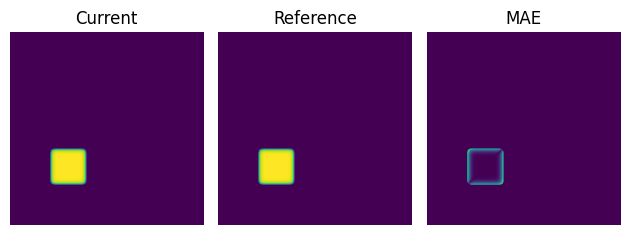

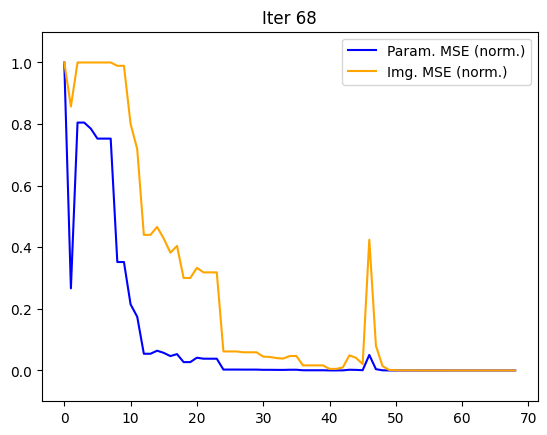

In [679]:
for i, theta in enumerate(starting_points):
    print(i)
    logging_box(theta.clone(), [], [], 0, 1)
    # --------------- run optimization CG
#     time1 = time.time()
    x_cg, func_loss, param_loss, iter_times = NCG_smooth(render_smooth, theta.clone(), cg_box_hparams['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
            sampler_args=sampler_args, opt_args=cg_box_hparams, ctx_args=ctx_args, device=device)
#     time2 = time.time()
#     box_time_hist[i, 0] = time2 - time1
#     param_loss = torch.nn.MSELoss()(x_cg, gt_theta).item()
#     box_loss_hist[i, 0] = param_loss#render_smooth(x_cg, f_args['gt_img'])
    iter_times = np.insert(iter_times, 0, 0)
    np.save(f'./results/box_2param/box_2param_cg/box_2param_cg_f_loss_{i}.npy', func_loss)
    np.save(f'./results/box_2param/box_2param_cg/box_2param_cg_param_loss_{i}.npy', param_loss)
    np.save(f'./results/box_2param/box_2param_cg/box_2param_cg_times_{i}.npy', iter_times)
    


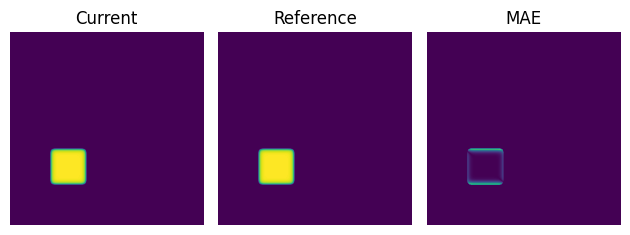

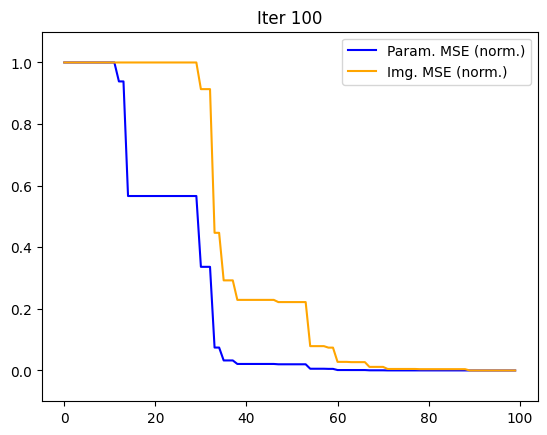

Iter 101 - Img.Loss: 0.0000 - Param.Loss: 0.0009
Iter 102 - Img.Loss: 0.0000 - Param.Loss: 0.0009
Iter 103 - Img.Loss: 0.0000 - Param.Loss: 0.0009
Iter 104 - Img.Loss: 0.0000 - Param.Loss: 0.0009
converged at:  104


In [680]:
for i, theta in enumerate(starting_points):
    print(i)
    logging_box(theta.clone(), [], [], 0, 1)
#     time2 = time.time()
    # --------------- run optimization newton
    x_newton, func_loss, param_loss, iter_times = newton_smooth(render_smooth, theta.clone(), newton_box_params['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
            sampler_args=sampler_args, opt_args=newton_box_params, ctx_args=ctx_args, device=device)
    while func_loss[-1] > 1e-5:
        x_newton, func_loss, param_loss, iter_times = newton_smooth(render_smooth, theta.clone(), newton_box_params['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
                sampler_args=sampler_args, opt_args=newton_box_params, ctx_args=ctx_args, device=device)
#     time3 = time.time()
#     box_time_hist[i, 1] = time3 - time2
#     param_loss = torch.nn.MSELoss()(x_newton, gt_theta).item()
#     box_loss_hist[i, 1] = param_loss#render_smooth(x_newton, f_args['gt_img'])
    np.save(f'./results/box_2param/box_2param_newton/box_2param_newton_f_loss_{i}.npy', func_loss)
    np.save(f'./results/box_2param/box_2param_newton/box_2param_newton_param_loss_{i}.npy', param_loss)
    np.save(f'./results/box_2param/box_2param_newton/box_2param_newton_times_{i}.npy', iter_times)
    


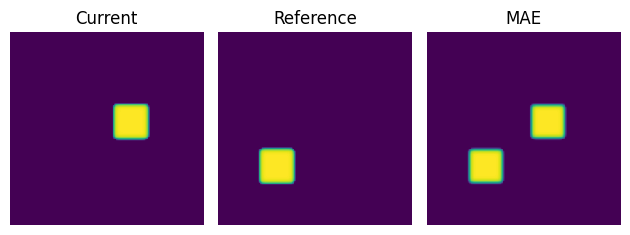

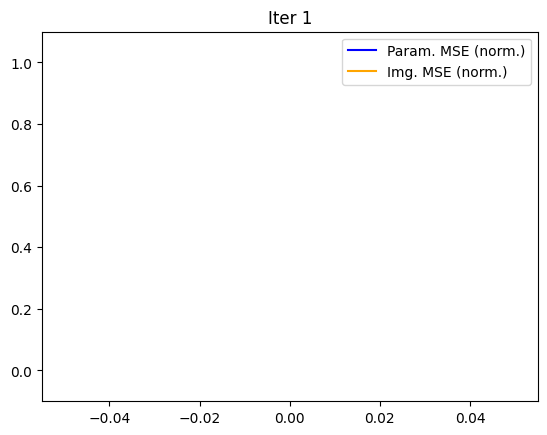

Iter 1 - Img.Loss: 0.0520 - Param.Loss: 1270.4539
Iter 2 - Img.Loss: 0.0520 - Param.Loss: 1270.4539
Iter 3 - Img.Loss: 0.0520 - Param.Loss: 1270.1604
Iter 4 - Img.Loss: 0.0520 - Param.Loss: 1270.0264
Iter 5 - Img.Loss: 0.0520 - Param.Loss: 1270.0264
Iter 6 - Img.Loss: 0.0520 - Param.Loss: 1265.4335
Iter 7 - Img.Loss: 0.0520 - Param.Loss: 1263.1130
Iter 8 - Img.Loss: 0.0520 - Param.Loss: 1153.9138
Iter 9 - Img.Loss: 0.0411 - Param.Loss: 149.4900
Iter 10 - Img.Loss: 0.0403 - Param.Loss: 144.7228
Iter 11 - Img.Loss: 0.0151 - Param.Loss: 18.7855
Iter 12 - Img.Loss: 0.0098 - Param.Loss: 10.6982
Iter 13 - Img.Loss: 0.0027 - Param.Loss: 1.9503
Iter 14 - Img.Loss: 0.0012 - Param.Loss: 0.7433
Iter 15 - Img.Loss: 0.0012 - Param.Loss: 0.7514
Iter 16 - Img.Loss: 0.0012 - Param.Loss: 0.7514
Iter 17 - Img.Loss: 0.0012 - Param.Loss: 0.7355
Iter 18 - Img.Loss: 0.0012 - Param.Loss: 0.7355
Iter 19 - Img.Loss: 0.0012 - Param.Loss: 0.7351
Iter 20 - Img.Loss: 0.0012 - Param.Loss: 0.7338
Iter 21 - Img.Loss:

KeyboardInterrupt: 

In [123]:
for i, theta in enumerate(starting_points):
    print(i)
    logging_box(theta.clone(), [], [], 0, 1)
    time3 = time.time()
    x_BFGS, _, _ = BFGS_opt(render_smooth, theta.clone(), BFGS_box_params['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args,
                    sampler_args=sampler_args, opt_args=BFGS_box_params, ctx_args=ctx_args, device=device)
    time4 = time.time()
    box_loss_hist[i, 2] = torch.nn.MSELoss()(x_BFGS, gt_theta).item()
    box_time_hist[i, 2] = time4 - time3

In [4]:
# # michaels

# def render_smooth_mi(perturbed_theta, update_fn, ctx_args):
#   with torch.no_grad():
#       imgs, losses = [], []
#       for j in range(perturbed_theta.shape[0]):       # for each sample
#           perturbed_img = get_rendering(perturbed_theta[j, :])
#           perturbed_loss = torch.nn.MSELoss()(perturbed_img, ctx_args['gt_image'])
#           imgs.append(perturbed_img)
#           losses.append(perturbed_loss)
#       avg_img = torch.mean(torch.cat([x.unsqueeze(0) for x in imgs], dim=0), dim=0)
#       loss = torch.stack(losses)
#   return loss, avg_img

# # def mi_opt(x0, max_iter, log_func, opt_args, ctx_args, device='cuda'):
# #     self_ctx_args = ctx_args.copy()
# #     x0 = x0.clone().detach().requires_grad_(True)
# #     optim = torch.optim.Adam([x0], lr=opt_args['learning_rate'])
# #     get_smoothed_loss = smoothFn(render_smooth_mi,context_args=None,device=device)
# #     conv_thres = opt_args.get('conv_thres', 10)
# #     img_errors, param_errors = [], []
# #     convergence = 0
# #     converged = False
# #     sigma = self_ctx_args['sigma']
# #     for i in range(max_iter):
# #         optim.zero_grad()
# #         self_ctx_args['sigma'] = sigma
# #         loss, _ = get_smoothed_loss(x0.unsqueeze(0), self_ctx_args)
# #         optim.step()
# #         loss.backward()
# #         optim.step()
# #         img_errors, param_errors = log_func(x0.unsqueeze(0), img_errors, param_errors, i, interval=opt_args['plot_interval'])
# #         if torch.norm(x0.grad) < opt_args['tol']:
# #             if converged:
# #                 convergence += 1
# #             else:
# #                 convergence = 1
# #             converged = True
# #             # print(convergence)
# #             if convergence >= conv_thres:
# #                 if torch.norm(x0.grad)< opt_args['tol']:
# #                     break
# #                 else:
# #                     convergence = 0
# #         else:
# #             converged = False
# #         if opt_args.get('sigma_annealing', False):
# #             sigma = sigma_scheduler(i, opt_args, sigma)
# #     return x0, img_errors, param_errors


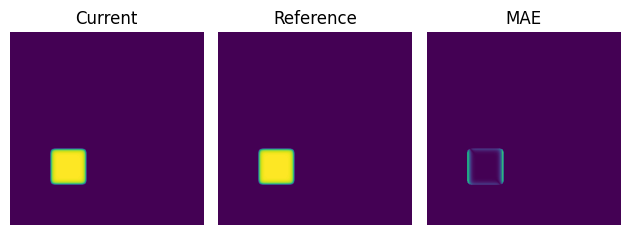

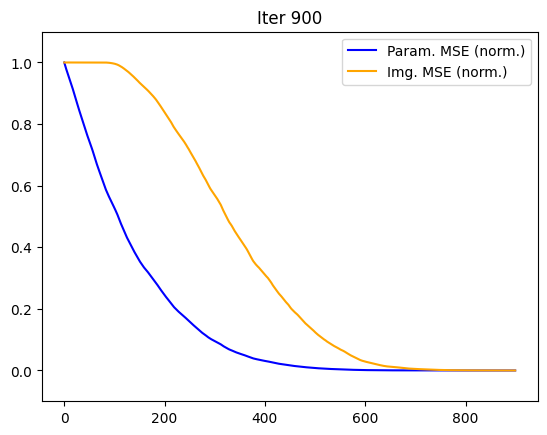

Iter 901 - Img.Loss: 0.0000 - Param.Loss: 0.0117
Iter 902 - Img.Loss: 0.0000 - Param.Loss: 0.0113
Iter 903 - Img.Loss: 0.0000 - Param.Loss: 0.0110
Iter 904 - Img.Loss: 0.0000 - Param.Loss: 0.0106
Iter 905 - Img.Loss: 0.0000 - Param.Loss: 0.0103
Iter 906 - Img.Loss: 0.0000 - Param.Loss: 0.0100
Iter 907 - Img.Loss: 0.0000 - Param.Loss: 0.0097
Iter 908 - Img.Loss: 0.0000 - Param.Loss: 0.0094
Iter 909 - Img.Loss: 0.0000 - Param.Loss: 0.0091
Iter 910 - Img.Loss: 0.0000 - Param.Loss: 0.0088
Iter 911 - Img.Loss: 0.0000 - Param.Loss: 0.0085
Iter 912 - Img.Loss: 0.0000 - Param.Loss: 0.0082
Iter 913 - Img.Loss: 0.0000 - Param.Loss: 0.0080
Iter 914 - Img.Loss: 0.0000 - Param.Loss: 0.0077
Iter 915 - Img.Loss: 0.0000 - Param.Loss: 0.0075
Iter 916 - Img.Loss: 0.0000 - Param.Loss: 0.0072
Iter 917 - Img.Loss: 0.0000 - Param.Loss: 0.0070
Iter 918 - Img.Loss: 0.0000 - Param.Loss: 0.0067
Iter 919 - Img.Loss: 0.0000 - Param.Loss: 0.0065
Iter 920 - Img.Loss: 0.0000 - Param.Loss: 0.0062
Iter 921 - Img.Loss:

In [516]:
show_with_error(init_img, ref_img, iter=0)
for i, theta in enumerate(starting_points):
    print(i)
    logging_box(theta.clone(), [], [], 0, 1)
    # --------------- run optimization MI
    # time1 = time.time()

    x_mi, func_loss, param_loss, iter_times = mi_opt(render_smooth, theta.clone(), mi_box2_params['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
                                            sampler_args=sampler_args, opt_args=mi_box2_params, ctx_args=ctx_args, device=device)
    # time2 = time.time()
    # box_time_hist[i, -1] = time2 - time1
    # param_loss = torch.nn.MSELoss()(x_mi, gt_theta).item()
    # box_loss_hist[i, -1] = param_loss#render_smooth(x_mi, f_args['gt_img'])
    np.save(f'./results/box_2param/box_2param_mi/box_2param_mi_f_loss_{i}.npy', func_loss)
    np.save(f'./results/box_2param/box_2param_mi/box_2param_mi_param_loss_{i}.npy', param_loss)
    np.save(f'./results/box_2param/box_2param_mi/box_2param_mi_times_{i}.npy', iter_times)
    

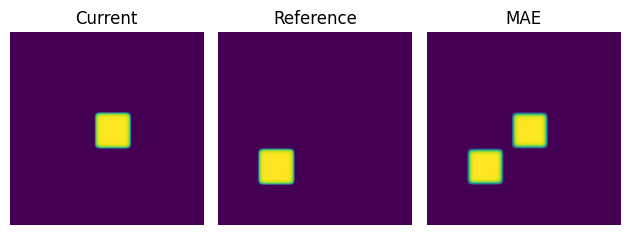

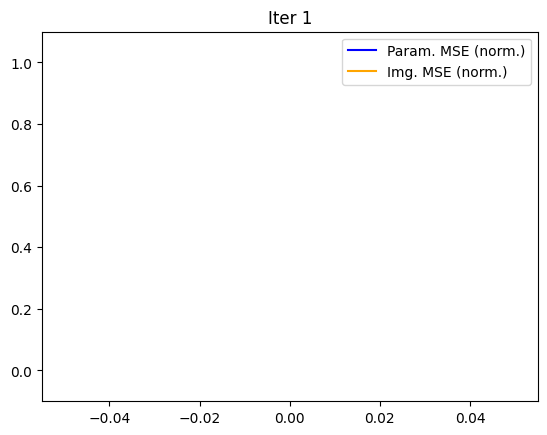

Iter 1 - Img.Loss: 0.0520 - Param.Loss: 10819.5508
Iter 2 - Img.Loss: 0.0520 - Param.Loss: 10737.9238
Iter 3 - Img.Loss: 0.0520 - Param.Loss: 10655.6602
Iter 4 - Img.Loss: 0.0520 - Param.Loss: 10571.7627
Iter 5 - Img.Loss: 0.0520 - Param.Loss: 10485.3262
Iter 6 - Img.Loss: 0.0520 - Param.Loss: 10398.4473
Iter 7 - Img.Loss: 0.0520 - Param.Loss: 10310.4805
Iter 8 - Img.Loss: 0.0520 - Param.Loss: 10226.5996
Iter 9 - Img.Loss: 0.0520 - Param.Loss: 10143.6826
Iter 10 - Img.Loss: 0.0520 - Param.Loss: 10065.0234
Iter 11 - Img.Loss: 0.0520 - Param.Loss: 9982.4756
Iter 12 - Img.Loss: 0.0520 - Param.Loss: 9900.8574
Iter 13 - Img.Loss: 0.0520 - Param.Loss: 9817.4688
Iter 14 - Img.Loss: 0.0520 - Param.Loss: 9736.7715
Iter 15 - Img.Loss: 0.0520 - Param.Loss: 9657.4814
Iter 16 - Img.Loss: 0.0520 - Param.Loss: 9576.2617
Iter 17 - Img.Loss: 0.0520 - Param.Loss: 9494.8125
Iter 18 - Img.Loss: 0.0520 - Param.Loss: 9412.4473
Iter 19 - Img.Loss: 0.0520 - Param.Loss: 9328.9268
Iter 20 - Img.Loss: 0.0520 - P

In [515]:
for i, theta in enumerate(starting_points):
    print(i)
    logging_box(theta.clone(), [], [], 0, 1)
    # --------------- run optimization Adam
    
    # for j, lr in enumerate(lr_list):
    adam_box_params['learning_rate'] = 0.5
    # time4 = time.time()
    x_adam, func_loss, param_loss, iter_times = adam_opt(render_smooth, theta.clone(), adam_box_params['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args,
                    sampler_args=sampler_args, opt_args=adam_box_params, ctx_args=ctx_args, device=device)
    np.save(f'./results/box_2param/box_2param_adam/box_2param_adam_f_loss_{i}.npy', func_loss)
    np.save(f'./results/box_2param/box_2param_adam/box_2param_adam_param_loss_{i}.npy', param_loss)
    np.save(f'./results/box_2param/box_2param_adam/box_2param_adam_times_{i}.npy', iter_times)
    # time5 = time.time()
    # box_time_hist[i, 3+j] = time5 - time4
    # param_loss = torch.nn.MSELoss()(x_adam, gt_theta).item()
    # box_loss_hist[i, 3+j] = param_loss#render_smooth(x_adam.unsqueeze(0), f_args['gt_img'])
    
    

In [229]:
np.save('box_loss_hist.npy', box_loss_hist)
np.save('box_time_hist.npy', box_time_hist)
box_loss_hist = np.load('box_loss_hist.npy')
box_time_hist = np.load('box_time_hist.npy')

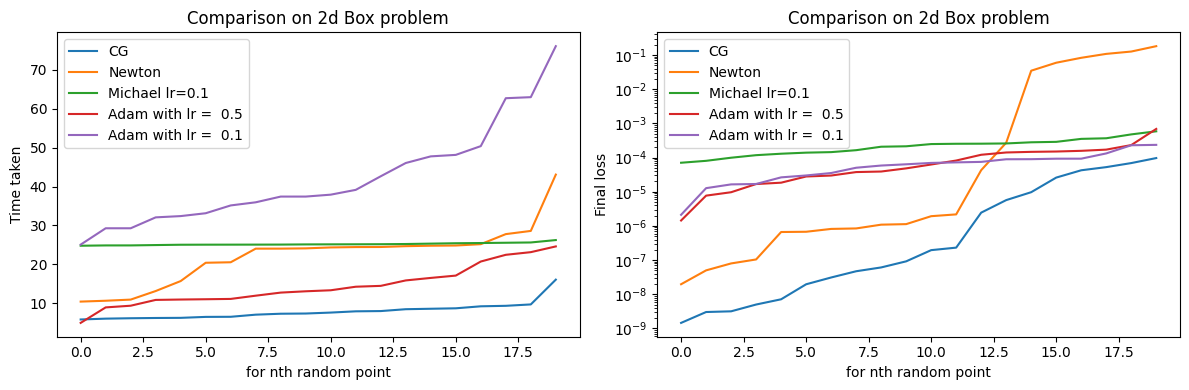

In [230]:
# Draw time plot and loss plot
box_loss_hist = np.sort(box_loss_hist, axis=0)
box_time_hist = np.sort(box_time_hist, axis=0)
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(box_time_hist[:, 0], label='CG')
plt.plot(box_time_hist[:, 1], label='Newton')
# plt.plot(box_time_hist[:, 2], label='BFGS')
plt.plot(box_time_hist[:, -1], label='Michael lr={}'.format(mi_hparams['learning_rate']))
for i, lr in enumerate(lr_list):
    plt.plot(box_time_hist[:, 3+i], label='Adam with lr =  {}'.format(lr))
plt.xlabel('for nth random point')
plt.ylabel('Time taken')
plt.title('Comparison on 2d Box problem')
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(box_loss_hist[:, 0], label='CG')
plt.plot(box_loss_hist[:, 1], label='Newton')
# plt.plot(box_loss_hist[:, 2], label='BFGS')
plt.plot(box_loss_hist[:, -1], label='Michael lr={}'.format(mi_hparams['learning_rate']))
for i, lr in enumerate(lr_list):
    plt.plot(box_loss_hist[:, 3+i], label='Adam with lr =  {}'.format(lr))
plt.xlabel('for nth random point')
plt.ylabel('Final loss')
plt.yscale('log')
plt.title('Comparison on 2d Box problem')
plt.legend()
plt.tight_layout()
# print(box_loss_hist)
# print(box_time_hist)

CG average time: 5.308585286140442
CG average time for 0.1 percentile in function loss: 1.6999207615852356
CG average time for 0.1 percentile in parameter loss: 0.9428372263908387
CG average time for 0.01 percentile in function loss: 2.7833953499794006
CG average time for 0.01 percentile in parameter loss: 1.5368195533752442
CG average time for 0.001 percentile in function loss: 3.458176040649414
CG average time for 0.001 percentile in parameter loss: 2.051884579658508
FR22 average time: 10.082633566856384
FR22 average time for 0.1 percentile in function loss: 5.928452265262604
FR22 average time for 0.1 percentile in parameter loss: 3.4499680757522584
FR22 average time for 0.01 percentile in function loss: 7.264882910251617
FR22 average time for 0.01 percentile in parameter loss: 5.292995405197144
FR22 average time for 0.001 percentile in function loss: 8.22250701189041
FR22 average time for 0.001 percentile in parameter loss: 6.599316251277924
Adam average time: 8.9251158118248
Adam a

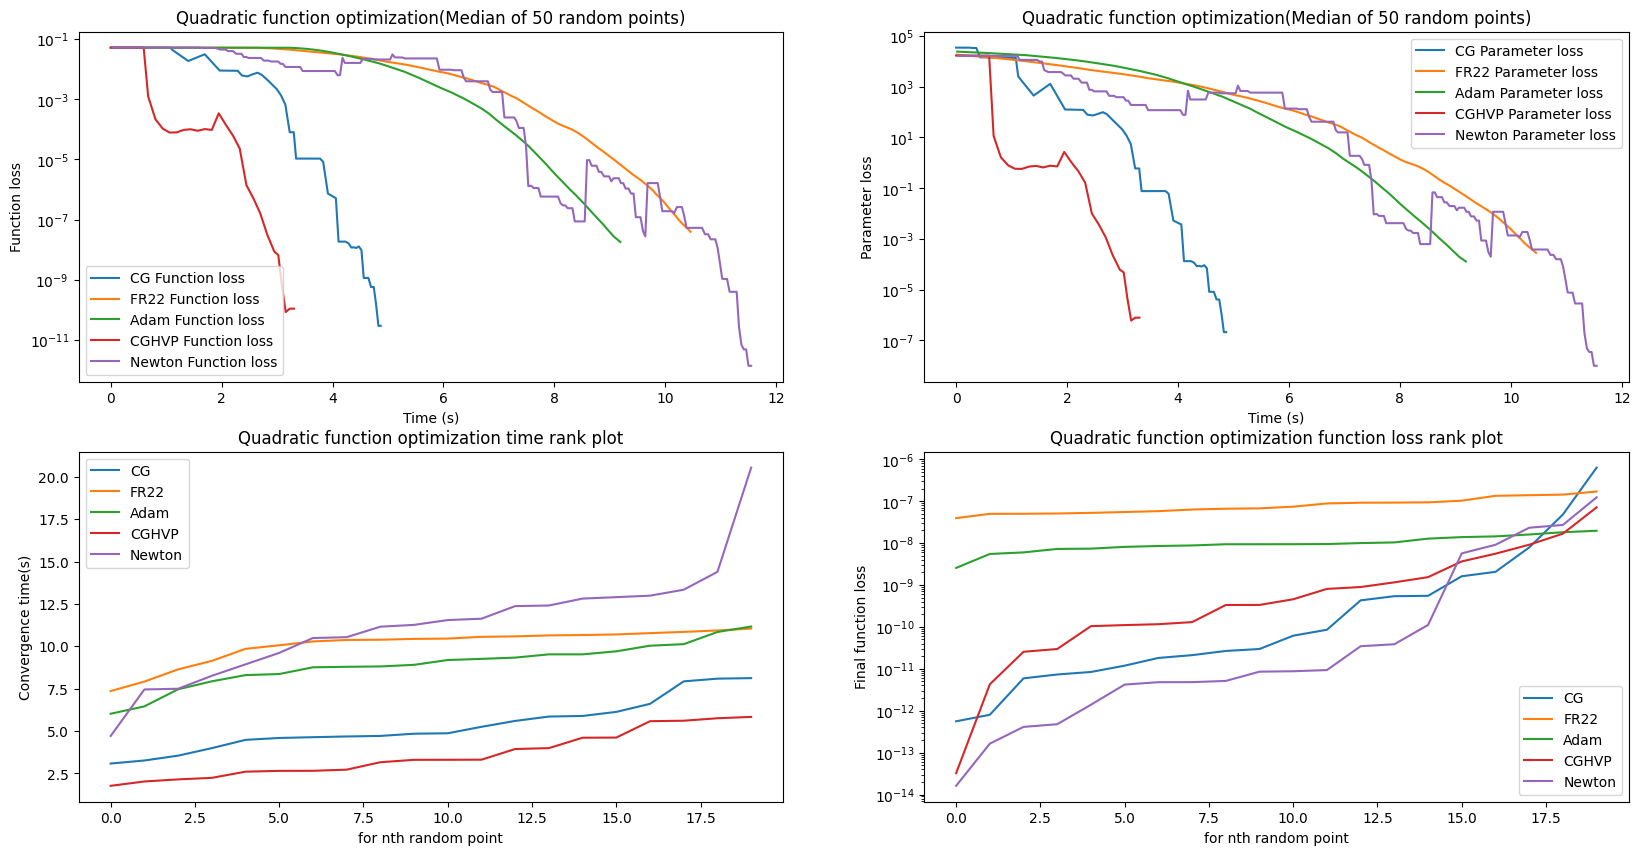

In [686]:
# np.save('potential_loss_hist.npy', loss_hist)
# np.save('potential_time_hist.npy', time_hist)

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
task = 'box_2param'
path = './results/' + task + '/'
opts = ['cg', 'mi', 'adam', 'cg_HVP', 'newton']
opt_names = ['CG', 'FR22', 'Adam', 'CGHVP', 'Newton']
percentiles = [0.1, 0.01, 1e-3]

final_times = {'final_times_cg':[],
                'final_times_mi': [],
                'final_times_adam': [],
                'final_times_cg_HVP': [],
                'final_times_newton': []
                }
final_conv = {'final_conv_cg':[],
            'final_conv_mi': [],
            'final_conv_adam': [],
            'final_conv_cg_HVP': [],
            'final_conv_newton': []
            }

mean_final_times = np.zeros((len(opts), n_starting_points))
mean_f_percentile_times = np.zeros((len(opts), len(percentiles), n_starting_points))
mean_param_percentile_times = np.zeros((len(opts), len(percentiles), n_starting_points))

for i in range(n_starting_points):
    for j in range(len(opts)):
        iter_times = np.load(path + task + '_' + opts[j] + '/' + task + '_' + opts[j] + f'_times_{i}.npy')
        f_loss = np.load(path + task + '_' + opts[j] + '/' + task + '_' + opts[j] + f'_f_loss_{i}.npy')
        param_loss = np.load(path + task + '_' + opts[j] + '/' + task + '_' + opts[j] + f'_param_loss_{i}.npy')
        times = np.cumsum(iter_times)
        
        final_times['final_times_'+opts[j]].append(times[-1])
        final_conv['final_conv_'+opts[j]].append([f_loss[-1].squeeze(), param_loss[-1].squeeze()])
        mean_final_times[j, i] = times[-1] 
        # for percentile time
        for l, percentile in enumerate(percentiles):
            initial_f_error = f_loss[0].squeeze()
            initial_param_error = param_loss[0].squeeze()
            for k, f_error in enumerate(f_loss):
                if f_error <= initial_f_error*percentile:
                    mean_f_percentile_times[j, l, i] = times[k]
                    break
            for k, param_error in enumerate(param_loss.squeeze()):
                if param_error <= initial_param_error*percentile:
                    mean_param_percentile_times[j, l, i] = times[k]
                    break
        

mean_final_times = mean_final_times.mean(axis=1)
mean_f_percentile_times = mean_f_percentile_times.mean(axis=2)
mean_param_percentile_times = mean_param_percentile_times.mean(axis=2)
# print(mean_final_times)
    
for i in range(len(opts)):
    median_id = np.argsort(final_times['final_times_'+opts[i]])[len(final_times['final_times_'+opts[i]])//2]
    sorted_conv = np.sort(final_conv['final_conv_'+opts[i]], axis=0)
    sorted_time = np.sort(final_times['final_times_'+opts[i]])
    
    iter_times = np.load(path + task + '_' + opts[i] + '/' + task + '_' + opts[i] + f'_times_{median_id}.npy')
    f_loss = np.load(path + task + '_' + opts[i] + '/' + task + '_' + opts[i] + f'_f_loss_{median_id}.npy')
    param_loss = np.load(path + task + '_' + opts[i] + '/' + task + '_' + opts[i] + f'_param_loss_{median_id}.npy')
    times = np.cumsum(iter_times)
    label_prefix = opt_names[i]
        
        
    print(f'{label_prefix} average time: {mean_final_times[i]}')
    for j in range(len(percentiles)):
        print(f'{label_prefix} average time for {percentiles[j]} percentile in function loss: {mean_f_percentile_times[i, j]}')
        print(f'{label_prefix} average time for {percentiles[j]} percentile in parameter loss: {mean_param_percentile_times[i, j]}')
    
    ax[0,0].plot(times, f_loss, label=label_prefix + ' Function loss')
    ax[0,1].plot(times, param_loss.squeeze(), label=label_prefix+' Parameter loss')
    ax[1,0].plot(sorted_time, label=label_prefix)
    ax[1,1].plot(sorted_conv[:,0], label=label_prefix)
    
ax[1,0].set_xlabel('for nth random point')
ax[1,0].set_ylabel('Convergence time(s)')
ax[1,0].set_title('Quadratic function optimization time rank plot')
ax[1,0].legend()

ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('for nth random point')
ax[1,1].set_ylabel('Final function loss')
ax[1,1].set_title('Quadratic function optimization function loss rank plot')
ax[1,1].legend()

ax[0,0].legend()
ax[0,1].legend()
ax[0,0].set_xlabel('Time (s)')
ax[0,0].set_ylabel('Function loss')
ax[0,0].set_title('Quadratic function optimization(Median of 50 random points)')
ax[0,1].set_xlabel('Time (s)')
ax[0,1].set_ylabel('Parameter loss')
ax[0,1].set_title('Quadratic function optimization(Median of 50 random points)')
save_path = './results/' + task + '/' + task + '_task.pdf'
plt.savefig(save_path, format='pdf')
ax[0,0].set_yscale('log')
ax[0,1].set_yscale('log')
save_path = './results/' + task + '/' + task + '_task_log.pdf'
plt.savefig(save_path, format='pdf')

# Example on box 3D param

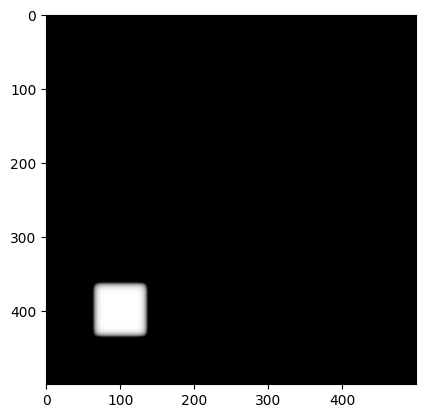

In [376]:
# From Michael's code box example
def get_rendering(theta,  update_fn=None, ctx_args=None): 
  return draw_rect_3param(theta[0], theta[1], theta[2])

scale = 500
def draw_rect_3param(px, py, size):   
  s, exp = scale, 10
  w, h = min(max(abs(size), 0.01*s), s/2), min(max(abs(size), 0.01*s), s/2)
  px = max(0+h, min(s-h, px))
  py = max(0+w, min(s-w, py))
  ss = torch.arange(s, device=device)
  x, y = torch.meshgrid(ss, ss)
  image = 1 - 2*(abs(((py - x)/w))**exp + abs((y - px)/h)**exp)
  return torch.flipud(image.clamp(0, 1)).unsqueeze(-1)

plt.imshow(draw_rect_3param(100, 100, 40).cpu().numpy().squeeze(), cmap='gray')

def render_smooth(perturbed_theta, gt_img):
  '''
  Michael's code but without the average image
  '''
  with torch.no_grad():
      imgs, losses = [], []
      for j in range(perturbed_theta.shape[0]):       # for each sample
          perturbed_img = get_rendering(perturbed_theta[j, :])
          perturbed_loss = torch.nn.MSELoss()(perturbed_img, gt_img)
          imgs.append(perturbed_img)
          losses.append(perturbed_loss)
      loss = torch.stack(losses)
  return loss

def logging_box(theta, img_errors, param_errors, i, interval=5, **f_args):
    # plotting, logging, printing...
    theta = theta.squeeze()
    img_curr = get_rendering(theta)
    img_loss = torch.nn.MSELoss()(img_curr, ref_img).item()
    param_loss = torch.nn.MSELoss()(abs(theta), gt_theta).item()
    img_errors.append(img_loss)
    param_errors.append(param_loss)

    print(f"Iter {i+1} - Img.Loss: {img_loss:.4f} - Param.Loss: {param_loss:.4f}")
    if (i+1) % interval == 0: 
        clear_output(wait=True)
        show_with_error(img_curr, ref_img, iter=i+1)
        plt_errors(img_errors, param_errors, title=f'Iter {i+1}')
    return img_errors, param_errors

n_samples = 10
sigma = 0.1

torch.manual_seed(0)

# set up initial and gt translation:
theta = torch.tensor([0.5, 0.6, 0.2], device=device)*scale
gt_theta = torch.tensor([0.3, 0.33, 0.15], device=device)*scale

init_img = get_rendering(theta)
ref_img = get_rendering(gt_theta)


## Individual test

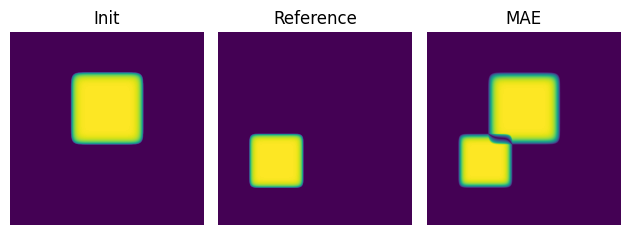

Starting NCG with sigma: 83.333333, TR: True, TR_bound: 20, HVP: False
Iter 1 - Img.Loss: 0.5805 - Param.Loss: 26283.3340
Iter 2 - Img.Loss: 0.5805 - Param.Loss: 555785.3750
Iter 3 - Img.Loss: 0.5805 - Param.Loss: 555785.3750


KeyboardInterrupt: 

In [377]:
# plt.rcParams['figure.figsize'] = (12, 6)
n_samples = 6
sigma = scale/6

ctx_args = {'nsamples':n_samples}
cg_box_hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 400,
           'anneal_const_first': 20,
           'anneal_const_last': 300,
           'anneal_sigma_min': 0.05,
           'tol': 5e-5, # tolerance for CG
           'HVP':False, # using HVP or full hessian
           'TR':True,
           'TR_bound': 20, # number or 'dynamic'
           'NR_max_iter': 300, # max iter for NR line search in CG
           'NR_tol': 1e-3, # tolerance for NR line search in CG
           'recompute': 1, # recompute the exact residual every n iterations
           'conv_thres': 5, # convergence threshold
           'plot_interval':20 # number of iterations to plot
           }
# --------------- run optimization CG
max_iter = cg_box_hparams['epochs']
theta = torch.tensor([0.5, 0.6, 0.6], device=device)*scale
show_with_error(init_img, ref_img, iter=0)
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler = 'importance_hessgauss'
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
x, _, x_list = NCG_smooth(render_smooth, theta, max_iter, log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
           sampler_args=sampler_args, opt_args=cg_box_hparams, ctx_args=ctx_args, device=device)
print(x_list)

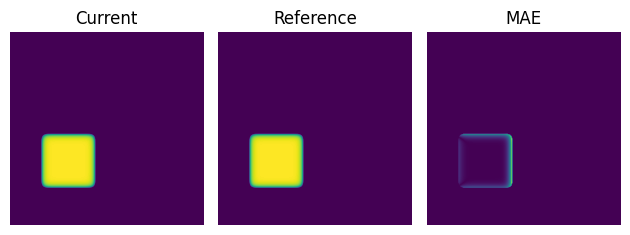

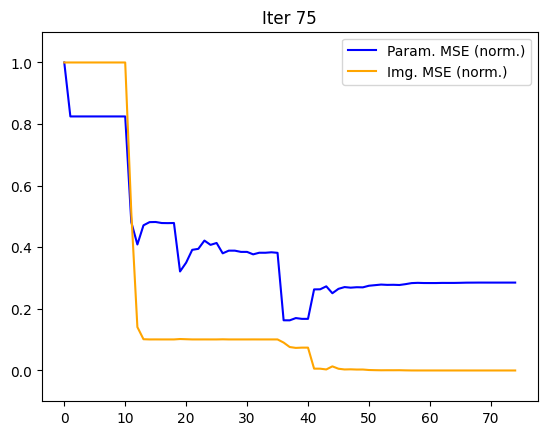

[[ 2.5000000e+02  3.0000000e+02  3.0000000e+02]
 [ 2.5224710e+02  2.9633182e+02  2.6821722e+02]
 [ 2.5224710e+02  2.9633182e+02  2.6821722e+02]
 [ 2.5224710e+02  2.9633182e+02  2.6821722e+02]
 [ 2.5224710e+02  2.9633182e+02  2.6821722e+02]
 [ 2.5224710e+02  2.9633182e+02  2.6821722e+02]
 [ 2.5224710e+02  2.9633182e+02  2.6821722e+02]
 [ 2.5224710e+02  2.9633182e+02  2.6821722e+02]
 [ 2.5224710e+02  2.9633182e+02  2.6821722e+02]
 [ 2.5224710e+02  2.9633182e+02  2.6821722e+02]
 [ 2.5224710e+02  2.9633182e+02  2.6821722e+02]
 [ 2.4688136e+02  3.0571738e+02  1.6880334e+02]
 [ 2.4222084e+02  3.1661688e+02  4.7320068e+01]
 [ 2.4145287e+02  3.2015494e+02  6.2355347e+00]
 [ 2.4131442e+02  3.2018628e+02  4.6372104e-01]
 [ 2.3959026e+02  3.2009918e+02 -2.0064003e+00]
 [ 2.3970404e+02  3.2020816e+02  1.0144089e-01]
 [ 2.3971028e+02  3.2014691e+02  1.4477420e-01]
 [ 2.3973656e+02  3.2015823e+02 -1.8598974e-02]
 [ 2.0106984e+02  3.0040878e+02  8.6449223e+00]
 [ 2.0297534e+02  3.0002325e+02 -6.03659

In [20]:
sigma = scale/10
cg_box_hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'anneal_const_first': 0,
           'anneal_const_last': 230,
           'anneal_sigma_min': 0.05,
           'epochs': 300,
           'conv_thres': 5, # convergence threshold
           'tol': 5e-5, # tolerance for CG
           'TR':True,
           'TR_bound': 'dynamic', # number or 'dynamic'
           'HVP':True, # using HVP or full hessian
           'NR_max_iter': 2, # max iter for NR line search in CG
           'NR_tol': 1e-3, # tolerance for NR line search in CG
           'recompute': 5, # recompute the exact residual every n iterations
           'plot_interval':20 # number of iterations to plot
           }
# --------------- run optimization CG
max_iter = cg_box_hparams['epochs']
theta = torch.tensor([0.5, 0.6, 0.6], device=device)*scale
show_with_error(init_img, ref_img, iter=0)
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler = 'importance_hessgauss'
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
x, _, x_list = NCG_smooth(render_smooth, theta, max_iter, log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
           sampler_args=sampler_args, opt_args=cg_box_hparams, ctx_args=ctx_args, device=device)
print(x_list)

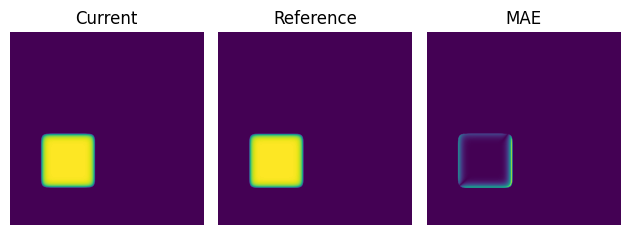

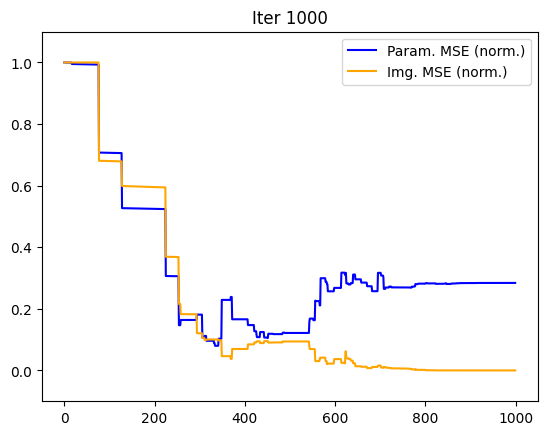

(tensor([[149.1795, 165.4975, -74.7092]], device='cuda:0'),
 array([[250.     , 300.     , 300.     ],
        [250.00092, 299.99918, 299.99396],
        [249.99976, 299.99847, 299.988  ],
        ...,
        [149.17952, 165.49748, -74.70917],
        [149.17952, 165.49748, -74.70917],
        [149.17952, 165.49748, -74.70917]], dtype=float32))

In [18]:
# newton
ctx_args = {'nsamples':n_samples}

newton_box_hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 1000,
           'anneal_const_first': 0,
           'anneal_const_last': 100,
           'anneal_sigma_min': 0.05,
           'TR':True,
           'TR_bound': 150,
           'TR_rate': 0.1,
           'learning_rate':0.5,
           'conv_thres': 7, # convergence threshold
           'tol': 5e-6, # tolerance for newton
           'hessian mod':True,
           'plot_interval':100 # number of iterations to plot
           }

# --------------- run optimization
max_iter = newton_box_hparams['epochs']
theta = torch.tensor([0.5, 0.6, 0.6], device=device)*scale
show_with_error(init_img, ref_img, iter=0)
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler = 'importance_hessgauss'
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
newton_smooth(render_smooth, theta, max_iter, log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
           sampler_args=sampler_args, opt_args=newton_box_hparams, ctx_args=ctx_args, device=device)


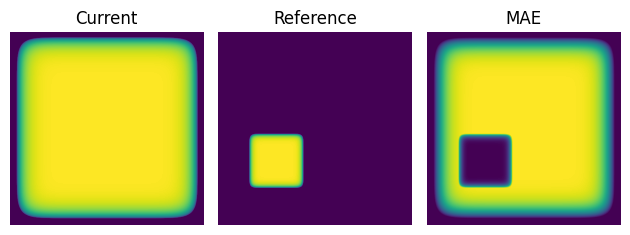

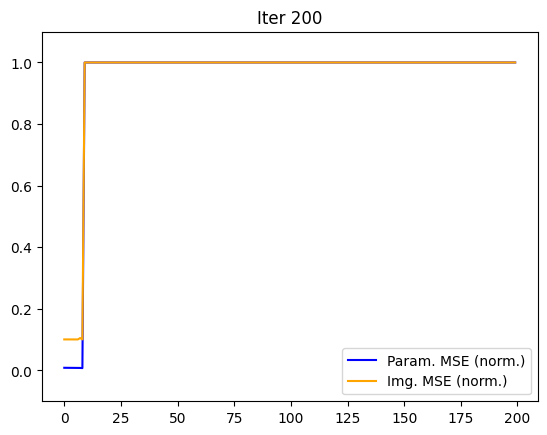

(tensor([[ -823.9872, -1708.6093, -1334.0074]], device='cuda:0',
        requires_grad=True),
 [0.058544762432575226,
  0.058512985706329346,
  0.058512523770332336,
  0.058512311428785324,
  0.0585089847445488,
  0.05850963294506073,
  0.0585089847445488,
  0.06111888214945793,
  0.05856526643037796,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.58052569627

In [55]:
# nBFGS
ctx_args = {'nsamples':n_samples}
sigma=scale/10
BFGS_box_hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 200,
           'anneal_const_first': 0,
           'anneal_const_last': 100,
           'anneal_sigma_min': 0.05,
           'TR':False,
           'TR_bound': 1e-3,
           'learning_rate':0.5,
           'line_search_fn': None, #'strong_wolfe',
           'history_size': 5,
           'tol': 5e-6, # tolerance for newton
           'plot_interval':100 # number of iterations to plot
           }

# --------------- run optimization
max_iter = BFGS_box_hparams['epochs']
theta = torch.tensor([0.5, 0.6, 0.6], device=device)*scale
show_with_error(init_img, ref_img, iter=0)
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler_args = {'sigma': sigma, 'is_antithetic': True}
BFGS_opt(render_smooth, theta, max_iter, log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
           sampler_args=sampler_args, opt_args=BFGS_box_hparams, ctx_args=ctx_args, device=device)

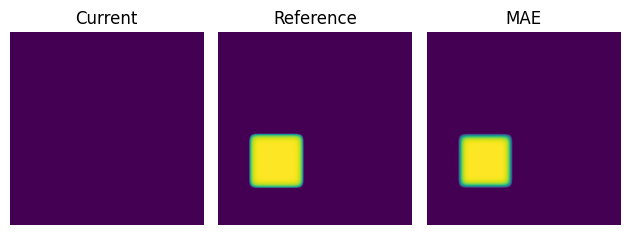

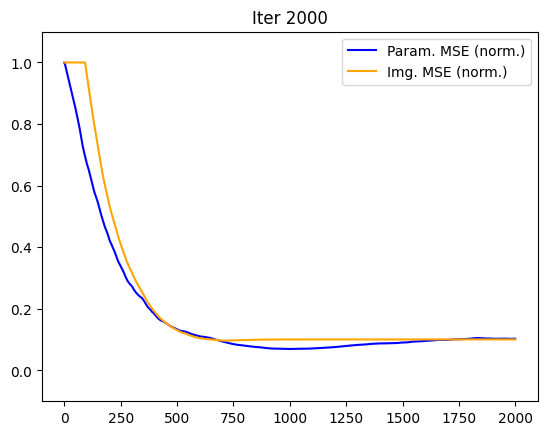

In [34]:
# adam
ctx_args = {'nsamples':n_samples}

adam_box_params = {'sigma_annealing': True,
           'sigma': sigma,
           'anneal_const_first': 400,
           'anneal_const_last': 1000,
           'anneal_sigma_min': 0.05,
           'epochs': 2000,
           'learning_rate':0.5,
           'plot_interval':100, # number of iterations to plot
           'conv_thres': 10, # convergence threshold
           'tol':1e-7
           }
# --------------- run optimization Adam
max_iter = adam_box_params['epochs']
theta = torch.tensor([0.5, 0.6, 0.6], device=device)*scale
show_with_error(init_img, ref_img, iter=0)
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler = 'importance_hessgauss'
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
x_adam, _, _ = adam_opt(render_smooth, theta, adam_box_params['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args,
                sampler_args=sampler_args, opt_args=adam_box_params, ctx_args=ctx_args, device=device)

In [27]:
mi_hparams = {'nsamples': n_samples,
            'sigma': sigma,
            'learning_rate': 0.1,
            'sigma_annealing': True,
            'epochs': 5000,
            'anneal_const_first': 500,
            'anneal_const_last': 1000,
            'anneal_sigma_min': 0.01,
            'conv_thres': 10, # convergence threshold
            'tol':1e-7,
            'plot_interval':200
           }

# set up mi_ctx_args: 
mi_ctx_args = {'antithetic': True, 'nsamples': mi_hparams['nsamples'], 'sigma': mi_hparams['sigma'],
            'sampler': 'importance', 'device': device, 'gt_image': ref_img, 'update_fn': None}

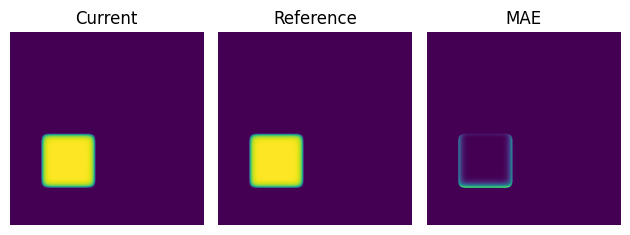

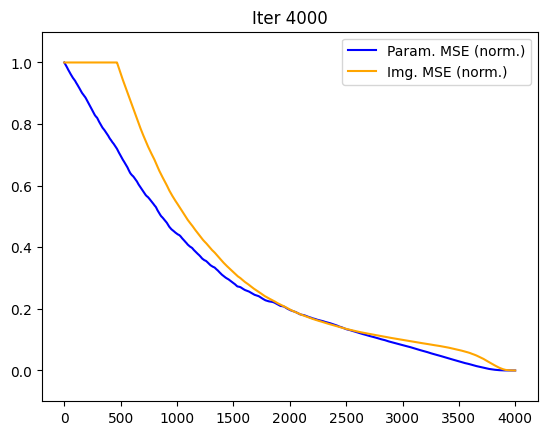

Iter 4001 - Img.Loss: 0.0000 - Param.Loss: 0.0491
Iter 4002 - Img.Loss: 0.0000 - Param.Loss: 0.0453
Iter 4003 - Img.Loss: 0.0000 - Param.Loss: 0.0420
Iter 4004 - Img.Loss: 0.0000 - Param.Loss: 0.0390
Iter 4005 - Img.Loss: 0.0000 - Param.Loss: 0.0360
Iter 4006 - Img.Loss: 0.0000 - Param.Loss: 0.0332
Iter 4007 - Img.Loss: 0.0000 - Param.Loss: 0.0307
Iter 4008 - Img.Loss: 0.0000 - Param.Loss: 0.0282
Iter 4009 - Img.Loss: 0.0000 - Param.Loss: 0.0260
Iter 4010 - Img.Loss: 0.0000 - Param.Loss: 0.0240
Iter 4011 - Img.Loss: 0.0000 - Param.Loss: 0.0222
Iter 4012 - Img.Loss: 0.0000 - Param.Loss: 0.0205
Iter 4013 - Img.Loss: 0.0000 - Param.Loss: 0.0189
Iter 4014 - Img.Loss: 0.0000 - Param.Loss: 0.0176
Iter 4015 - Img.Loss: 0.0000 - Param.Loss: 0.0163
Iter 4016 - Img.Loss: 0.0000 - Param.Loss: 0.0150
Iter 4017 - Img.Loss: 0.0000 - Param.Loss: 0.0138
Iter 4018 - Img.Loss: 0.0000 - Param.Loss: 0.0128
Iter 4019 - Img.Loss: 0.0000 - Param.Loss: 0.0117
Iter 4020 - Img.Loss: 0.0000 - Param.Loss: 0.0108


In [28]:
show_with_error(init_img, ref_img, iter=0)
    
theta = torch.tensor([0.5, 0.6, 0.6], device=device)*scale
logging_box(theta.clone(), [], [], 0, 1)
# --------------- run optimization MI
x_mi, _, _ = mi_opt(theta.clone(), mi_hparams['epochs'], log_func=logging_box, opt_args=mi_hparams, ctx_args=mi_ctx_args, device=device)

## Batch test

In [378]:
n_starting_points = 20
starting_points = (torch.rand(n_starting_points, 3, device=device)*torch.tensor([0.3, 0.3, 0.3], device=device) + torch.tensor([0.35, 0.35, 0.1], device=device))*scale
box_time_hist = np.zeros((n_starting_points, 3+2*len(lr_list))) # 1 for CG, 1 for Newton, 1 for BFGS, lr for michale, lr for adam
box_loss_hist = np.zeros((n_starting_points, 3+2*len(lr_list)))
np.save('./results/box_3param/box_sp.npy', starting_points.cpu())


In [381]:
# comparison
def log_none(*args, **kargs):
    return [],[]

gt_theta = torch.tensor([0.3, 0.3, 0.15], device=device)*scale
ref_img = get_rendering(gt_theta)

n_samples = 6
sigma = scale/20
ctx_args = {'nsamples':n_samples}

cg_box_hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 400,
           'anneal_const_first': 20,
           'anneal_const_last': 300,
           'anneal_sigma_min': 0.05,
           'tol': 5e-5, # tolerance for CG
           'TR':True,
           'HVP':False, # using HVP or full hessian
           'TR_bound': 20,
           'TR_rate': 0.5,
           'NR_max_iter': 300, # max iter for NR line search in CG
           'NR_tol': 1e-3, # tolerance for NR line search in CG
           'recompute': 1, # recompute the exact residual every n iterations
           'conv_thres': 5, # convergence threshold
           'plot_interval':20 # number of iterations to plot
           }

# cg_box_hparams = {'sigma_annealing': True,
#            'sigma': sigma,
#            'epochs': 300,
#            'anneal_const_first': 0,
#            'anneal_const_last': 230,
#            'anneal_sigma_min': 0.05,
#            'tol': 5e-5, # tolerance for CG
#            'HVP':True, # using HVP or full hessian
#            'TR':True,
#            'TR_bound': 'dynamic', # number or 'dynamic'
#            'NR_max_iter': 2, # max iter for NR line search in CG
#            'NR_tol': 1e-3, # tolerance for NR line search in CG
#            'recompute': 5, # recompute the exact residual every n iterations
#            'conv_thres': 5, # convergence threshold
#            'plot_interval':20 # number of iterations to plot
#            }

newton_box_hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 1200,
           'anneal_const_first': 200,
           'anneal_const_last': 0,
           'anneal_sigma_min': 0.05,
           'TR':True,
           'TR_bound': 200,
           'TR_rate': 1e-2,
           'learning_rate':0.5,
           'conv_thres': 7, # convergence threshold
           'tol': 5e-6, # tolerance for newton
           'hessian mod':True,
           'plot_interval':100 # number of iterations to plot
           }


adam_box_params = {'sigma_annealing': True,
           'sigma': sigma,
           'anneal_const_first': 200,
           'anneal_const_last': 0,
           'anneal_sigma_min': 0.01,
           'conv_thres': 10, # convergence threshold
           'epochs': 2000,
           'learning_rate':1e-1,
           'plot_interval':200, # number of iterations to plot
           'tol':1e-6
           }


BFGS_box_hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 200,
           'anneal_const_first': 0,
           'anneal_const_last': 100,
           'anneal_sigma_min': 0.05,
           'TR':False,
           'TR_bound': 1e-3,
           'learning_rate':0.5,
           'line_search_fn': None, #'strong_wolfe',
           'history_size': 5,
           'tol': 5e-6, # tolerance for newton
           'plot_interval':100 # number of iterations to plot
           }

mi_hparams = {'nsamples': n_samples,
            'sigma': sigma,
            'learning_rate': 0.1,
            'sigma_annealing': True,
            'epochs': 5000,
            'anneal_const_first': 0,
            'anneal_const_last': 0,
            'anneal_sigma_min': 0.05,
            'conv_thres': 10, # convergence threshold
            'tol':1e-6,
            'plot_interval':1000
           }

# set up mi_ctx_args: 
mi_ctx_args = {'antithetic': True, 'nsamples': mi_hparams['nsamples'], 'sigma': mi_hparams['sigma'],
            'sampler': 'importance', 'device': device, 'gt_image': ref_img, 'update_fn': None}
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}

# lr_list = [0.5, 0.1, 0.05, 0.01, 1e-3]
lr_list = [0.5, 0.1]
starting_points = np.load('./results/box_3param/box_sp.npy')
starting_points = torch.tensor(starting_points, device=device)

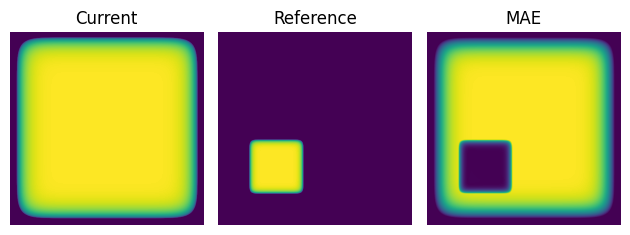

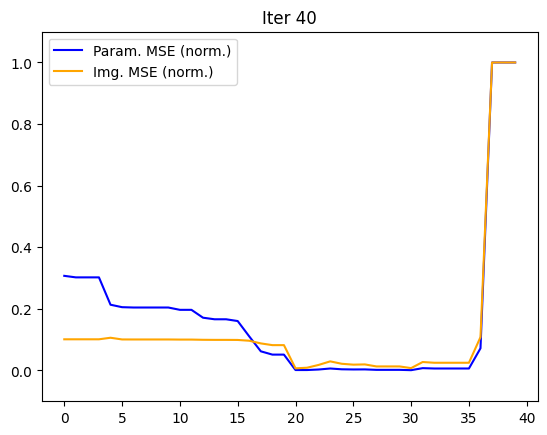

KeyboardInterrupt: 

In [380]:
for i, theta in enumerate(starting_points):
    print(i)
    logging_box(theta.clone(), [], [], 0, 1)
    # --------------- run optimization CG
    time1 = time.time()
    x_cg, img_loss, param_loss, iter_time = NCG_smooth(render_smooth, theta.clone(), cg_box_hparams['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
            sampler_args=sampler_args, opt_args=cg_box_hparams, ctx_args=ctx_args, device=device)
    time2 = time.time()
    box_time_hist[i, 0] = time2 - time1
    param_loss = torch.nn.MSELoss()(x_cg, gt_theta).item()
    box_loss_hist[i, 0] = render_smooth(x_cg, f_args['gt_img'])
    np.save(f'./results/box_3param/box_3param_cg/box_3param_cg_f_loss_{i}.npy', func_loss)
    np.save(f'./results/box_3param/box_3param_cg/box_3param_cg_param_loss_{i}.npy', param_loss)
    np.save(f'./results/box_3param/box_3param_cg/box_3param_cg_times_{i}.npy', time_iters)
    


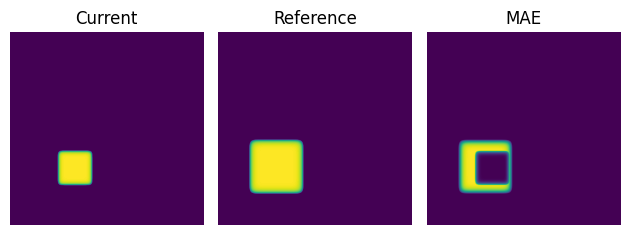

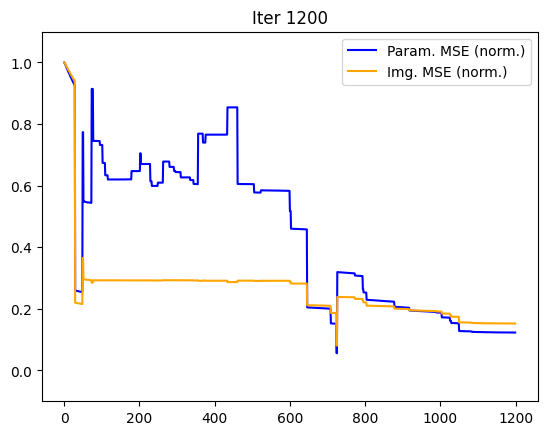

In [118]:
for i, theta in enumerate(starting_points):
    print(i)
    logging_box(theta.clone(), [], [], 0, 1)
    time2 = time.time()
    # --------------- run optimization newton
    
    x_newton, _ = newton_smooth(render_smooth, theta.clone(), newton_box_hparams['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
            sampler_args=sampler_args, opt_args=newton_box_hparams, ctx_args=ctx_args, device=device)
    time3 = time.time()
    box_time_hist[i, 1] = time3 - time2
    param_loss = torch.nn.MSELoss()(x_newton, gt_theta).item()
    box_loss_hist[i, 1] = render_smooth(x_newton, f_args['gt_img'])
    


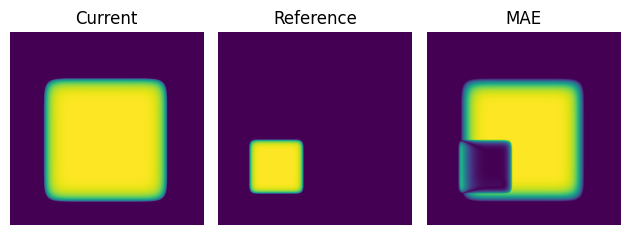

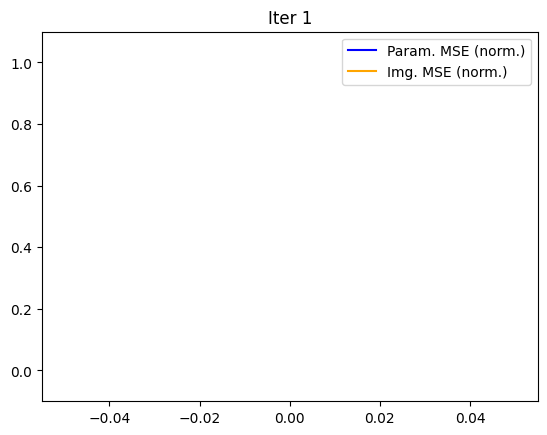

torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
Iter 1 - Img.Loss: 0.2381 - Param.Loss: 7363.5562
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size

KeyboardInterrupt: 

In [67]:
for i, theta in enumerate(starting_points):
    print(i)
    logging_box(theta.clone(), [], [], 0, 1)
    time3 = time.time()
    x_BFGS, _, _ = BFGS_opt(render_smooth, theta.clone(), BFGS_box_params['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args,
                    sampler_args=sampler_args, opt_args=BFGS_box_params, ctx_args=ctx_args, device=device)
    time4 = time.time()
    box_loss_hist[i, 2] = torch.nn.MSELoss()(x_BFGS, gt_theta).item()
    box_time_hist[i, 2] = time4 - time3

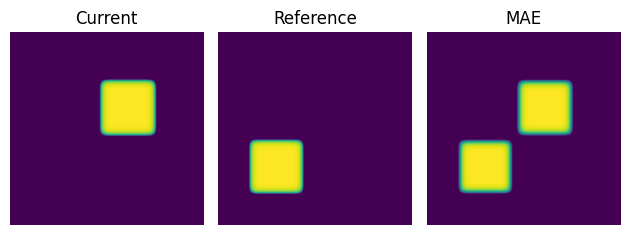

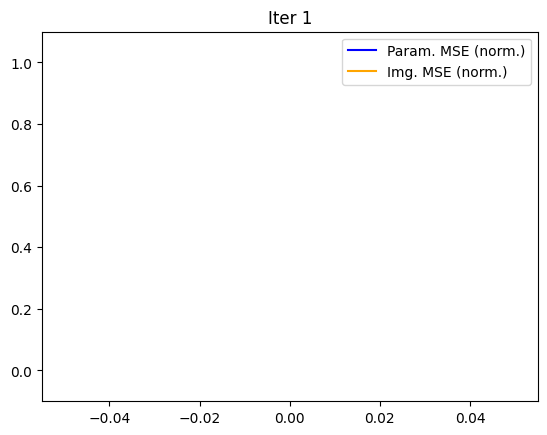

Iter 1 - Img.Loss: 0.1205 - Param.Loss: 15476.1543
Iter 2 - Img.Loss: 0.1197 - Param.Loss: 15456.2734
Iter 3 - Img.Loss: 0.1189 - Param.Loss: 15433.7451
Iter 4 - Img.Loss: 0.1181 - Param.Loss: 15431.8701
Iter 5 - Img.Loss: 0.1174 - Param.Loss: 15434.4014
Iter 6 - Img.Loss: 0.1166 - Param.Loss: 15404.0762
Iter 7 - Img.Loss: 0.1159 - Param.Loss: 15350.5107
Iter 8 - Img.Loss: 0.1151 - Param.Loss: 15288.4609
Iter 9 - Img.Loss: 0.1143 - Param.Loss: 15238.9873
Iter 10 - Img.Loss: 0.1136 - Param.Loss: 15193.3779
Iter 11 - Img.Loss: 0.1128 - Param.Loss: 15150.7734
Iter 12 - Img.Loss: 0.1121 - Param.Loss: 15111.4902
Iter 13 - Img.Loss: 0.1114 - Param.Loss: 15076.3467
Iter 14 - Img.Loss: 0.1107 - Param.Loss: 15044.2656
Iter 15 - Img.Loss: 0.1099 - Param.Loss: 15018.3193
Iter 16 - Img.Loss: 0.1092 - Param.Loss: 14984.4717
Iter 17 - Img.Loss: 0.1085 - Param.Loss: 14946.5293
Iter 18 - Img.Loss: 0.1078 - Param.Loss: 14916.7646
Iter 19 - Img.Loss: 0.1071 - Param.Loss: 14906.8848
Iter 20 - Img.Loss: 0

In [382]:
show_with_error(init_img, ref_img, iter=0)
for i, theta in enumerate(starting_points):
    print(i)
    logging_box(theta.clone(), [], [], 0, 1)
    # for j, lr in enumerate(lr_list):
    mi_hparams['learning_rate'] = 0.5
    # --------------- run optimization MI
    time1 = time.time()
    x_mi, img_loss, param_loss, iter_time = mi_opt(render_smooth, theta.clone(), mi_hparams['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
                                           sampler_args=sampler_args, opt_args=mi_hparams, ctx_args=ctx_args, device=device)
    np.save(f'./results/box_3param/box_3param_mi/box_3param_mi_f_loss_{i}.npy', func_loss)
    np.save(f'./results/box_3param/box_3param_mi/box_3param_mi_param_loss_{i}.npy', param_loss)
    np.save(f'./results/box_3param/box_3param_mi/box_3param_mi_times_{i}.npy', time_iters)
    time2 = time.time()
    # box_time_hist[i, 3+len(lr_list)+j] = time2 - time1
    # param_loss = torch.nn.MSELoss()(x_mi, gt_theta).item()
    # box_loss_hist[i, 3+len(lr_list)+j] = render_smooth(x_mi.unsqueeze(0), f_args['gt_img'])
    

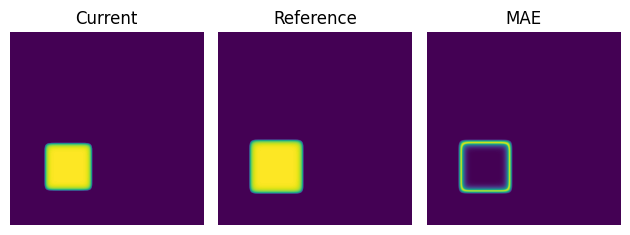

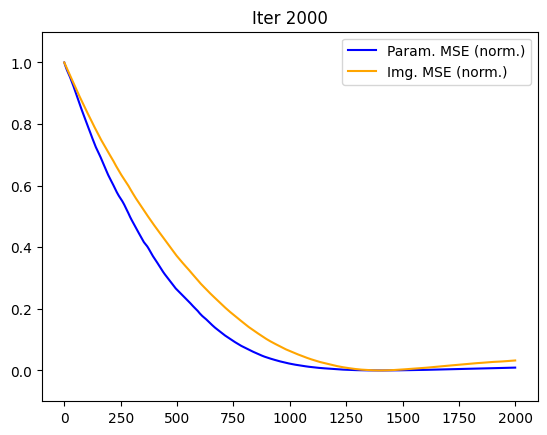

In [ ]:
for i, theta in enumerate(starting_points):
    print(i)
    logging_box(theta.clone(), [], [], 0, 1)
    # --------------- run optimization Adam
    
    for j, lr in enumerate(lr_list):
        adam_box_params['learning_rate'] = lr
        time4 = time.time()
        x_adam, _, _ = adam_opt(render_smooth, theta.clone(), adam_box_params['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args,
                        sampler_args=sampler_args, opt_args=adam_box_params, ctx_args=ctx_args, device=device)
        time5 = time.time()
        box_time_hist[i, 3+j] = time5 - time4
        param_loss = torch.nn.MSELoss()(x_adam, gt_theta).item()
        box_loss_hist[i, 3+j] = render_smooth(x_adam.unsqueeze(0), f_args['gt_img'])
    
    

In [ ]:
np.save('box_loss_hist.npy', box_loss_hist)
np.save('box_time_hist.npy', box_time_hist)
box_loss_hist = np.load('box_loss_hist.npy')
box_time_hist = np.load('box_time_hist.npy')

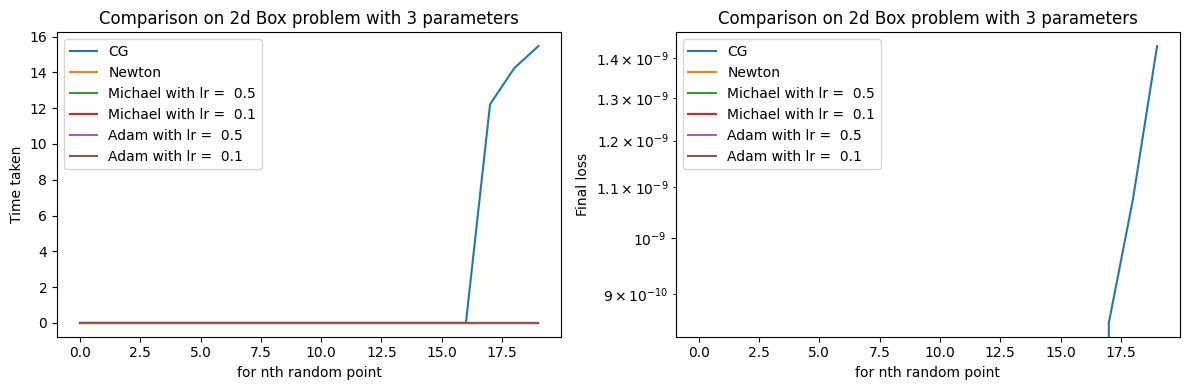

In [61]:
# Draw time plot and loss plot
box_loss_hist = np.sort(box_loss_hist, axis=0)
box_time_hist = np.sort(box_time_hist, axis=0)
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(box_time_hist[:, 0], label='CG')
plt.plot(box_time_hist[:, 1], label='Newton')
# plt.plot(box_time_hist[:, 2], label='BFGS')
for i, lr in enumerate(lr_list):
    plt.plot(box_time_hist[:, 3+i], label='Michael with lr =  {}'.format(lr))
for i, lr in enumerate(lr_list):
    plt.plot(box_time_hist[:, 3+len(lr_list)+i], label='Adam with lr =  {}'.format(lr))
plt.xlabel('for nth random point')
plt.ylabel('Time taken')
plt.title('Comparison on 2d Box problem with 3 parameters')
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(box_loss_hist[:, 0], label='CG')
plt.plot(box_loss_hist[:, 1], label='Newton')
# plt.plot(box_loss_hist[:, 2], label='BFGS')
for i, lr in enumerate(lr_list):
    plt.plot(box_loss_hist[:, 3+i], label='Michael with lr =  {}'.format(lr))
for i, lr in enumerate(lr_list):
    plt.plot(box_loss_hist[:, 3+len(lr_list)+i], label='Adam with lr =  {}'.format(lr))
plt.xlabel('for nth random point')
plt.ylabel('Final loss')
plt.yscale('log')
plt.title('Comparison on 2d Box problem with 3 parameters')
plt.legend()
plt.tight_layout()
# print(box_loss_hist)
# print(box_time_hist)